In [63]:
from IPython.display import display
import ipywidgets as widgets

upload = widgets.FileUpload()
display(upload)

# After uploading
for filename, fileinfo in upload.value.items():
    with open(filename, "wb") as f:
        f.write(fileinfo['content'])


FileUpload(value={}, description='Upload')

In [64]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

# Load the dataset
df = pd.read_csv("enhanced_sentiment_stock_data.csv")

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

Saving enhanced_sentiment_stock_data.csv to enhanced_sentiment_stock_data.csv


In [65]:
import pandas as pd

# Load your CSV
df = pd.read_csv("enhanced_sentiment_stock_data.csv")

# Define required feature columns
required_columns = [
    'CloseMA_3', 'CloseMA_5', 'CloseMA_10',
    'RSI', 'MACD', 'MACD_Signal',
    'BB_Upper', 'BB_Lower',
    'Volatility', 'Return', 'Volume_MA'
]

# Drop rows with missing values in either features or target
df_clean = df.dropna(subset=required_columns + ['Sentiment_Enhanced'])

# Define feature matrix X and target vector y
X = df_clean[required_columns]
y = df_clean['Sentiment_Enhanced']

# Check class balance
print(X.shape)
print(y.value_counts())


(1239, 11)
Sentiment_Enhanced
Bullish    650
Neutral    366
Bearish    223
Name: count, dtype: int64


Classification Report:
               precision    recall  f1-score   support

     Bearish       0.85      0.64      0.73        45
     Bullish       0.88      0.93      0.91       130
     Neutral       0.79      0.84      0.81        73

    accuracy                           0.85       248
   macro avg       0.84      0.80      0.82       248
weighted avg       0.85      0.85      0.85       248



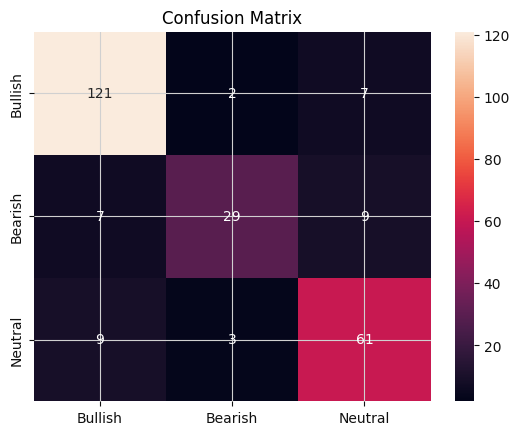

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train Random Forest
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Bullish','Bearish','Neutral'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Bullish','Bearish','Neutral'], yticklabels=['Bullish','Bearish','Neutral'])
plt.title('Confusion Matrix')
plt.show()


In [67]:
# Predict on full cleaned dataset
df_clean['ML_Predicted'] = model.predict(X)

# Map to Action
action_map = {'Bullish': 'Buy', 'Bearish': 'Sell', 'Neutral': 'Hold'}
df_clean['Action'] = df_clean['ML_Predicted'].map(action_map)

# Save to CSV
df_clean.to_csv('ml_predictions.csv', index=False)
print("Saved file: ml_predictions.csv")

# Check sample
print(df_clean[['Date','Close','Sentiment_Enhanced','ML_Predicted','Action']].head())


Saved file: ml_predictions.csv
          Date  Close Sentiment_Enhanced ML_Predicted Action
19  2013-03-11  51.40            Bullish      Bullish    Buy
20  2013-03-12  51.15            Bullish      Bullish    Buy
21  2013-03-13  52.39            Bullish      Bullish    Buy
22  2013-03-14  52.59            Bullish      Bullish    Buy
23  2013-03-15  52.40            Bullish      Bullish    Buy


/tmp/ipython-input-1283029148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ML_Predicted'] = model.predict(X)
/tmp/ipython-input-1283029148.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Action'] = df_clean['ML_Predicted'].map(action_map)


/tmp/ipython-input-1630429157.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Portfolio_Value'] = portfolio_value


Final Portfolio Value: 99999.61
Total Return: -0.00%
Number of Trades: 43


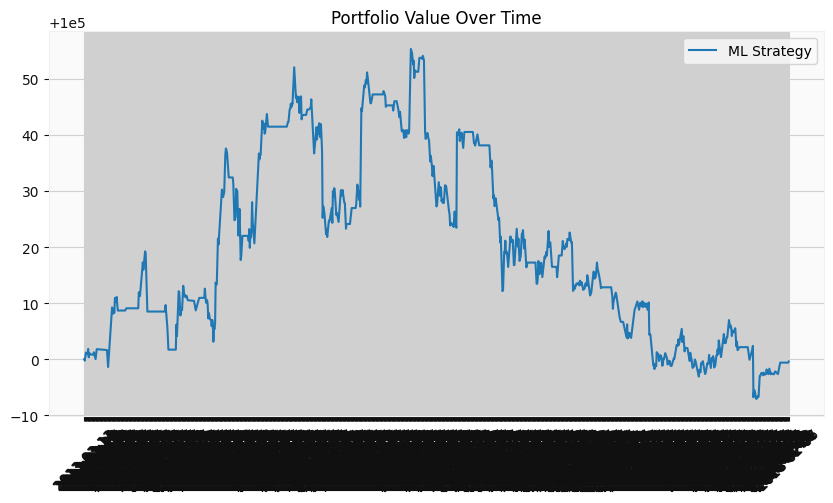

In [68]:
# Strategy 1 – Basic ML Backtest (No Risk Mgmt)
initial_capital = 100000
position = 0  # 0 means no position, 1 means long
entry_price = 0
cash = initial_capital
portfolio_value = []
trade_log = []

for i, row in df_clean.iterrows():
    action = row['Action']
    price = row['Close']

    if action == 'Buy' and position == 0:
        position = 1
        entry_price = price
        trade_log.append({'Date': row['Date'], 'Action': 'Buy', 'Price': price})

    elif action == 'Sell' and position == 1:
        position = 0
        pnl = (price - entry_price)
        cash += pnl
        trade_log.append({'Date': row['Date'], 'Action': 'Sell', 'Price': price, 'PnL': pnl})

    # Track portfolio value
    current_value = cash + (price - entry_price if position == 1 else 0)
    portfolio_value.append(current_value)

# Add portfolio value to dataframe
df_clean['Portfolio_Value'] = portfolio_value

# Convert trade log to DataFrame
trade_df = pd.DataFrame(trade_log)

# Final results
final_value = portfolio_value[-1]
total_return = ((final_value - initial_capital) / initial_capital) * 100

print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {len(trade_df)//2}")

# Save trade log
trade_df.to_csv('ml_trade_log.csv', index=False)

# Plot portfolio value
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df_clean['Date'], df_clean['Portfolio_Value'], label='ML Strategy')
plt.xticks(rotation=45)
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()


/tmp/ipython-input-70403331.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Portfolio_Value_Improved'] = portfolio_value


Final Portfolio Value: 99992.45
Total Return: -0.01%
Number of Trades: 97


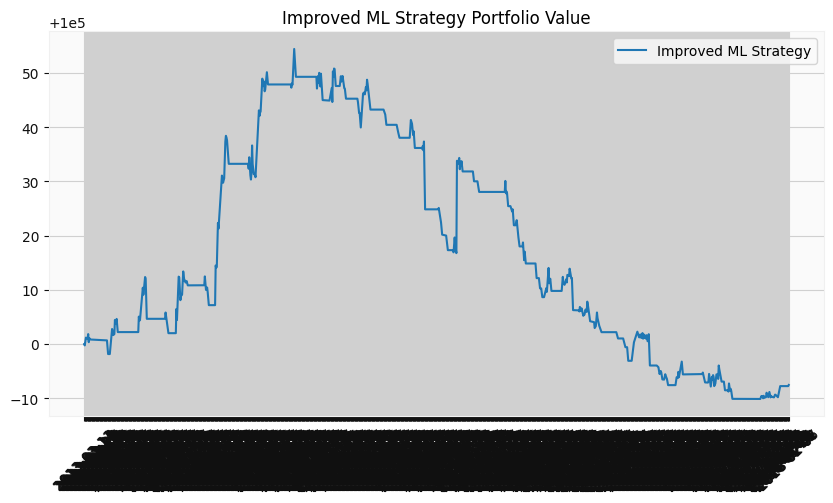

In [69]:
# Strategy 2 – Improved ML Backtest (MA Filter)
initial_capital = 100000
cash = initial_capital
position = 0  # 0 = no position, 1 = long
entry_price = 0
portfolio_value = []
trade_log = []

for i, row in df_clean.iterrows():
    signal = row['ML_Predicted']
    price = row['Close']
    ma10 = row['CloseMA_10']

    # Stop-loss / Take-profit check
    if position == 1:
        if price <= entry_price * 0.98 or price >= entry_price * 1.04:
            pnl = price - entry_price
            cash += pnl
            trade_log.append({'Date': row['Date'], 'Action': 'Exit (Stop/TP)', 'Price': price, 'PnL': pnl})
            position = 0

    # Entry condition
    if signal == 'Bullish' and position == 0 and price > ma10:
        position = 1
        entry_price = price
        trade_log.append({'Date': row['Date'], 'Action': 'Buy', 'Price': price})

    # Exit condition
    elif signal == 'Bearish' and position == 1 and price < ma10:
        position = 0
        pnl = price - entry_price
        cash += pnl
        trade_log.append({'Date': row['Date'], 'Action': 'Sell', 'Price': price, 'PnL': pnl})

    # Track portfolio value
    current_value = cash + (price - entry_price if position == 1 else 0)
    portfolio_value.append(current_value)

df_clean['Portfolio_Value_Improved'] = portfolio_value
trade_df = pd.DataFrame(trade_log)

final_value = portfolio_value[-1]
total_return = ((final_value - initial_capital) / initial_capital) * 100

print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {len(trade_df)//2}")

# Save trade log
trade_df.to_csv('ml_trade_log_improved.csv', index=False)

# Plot portfolio value
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df_clean['Date'], df_clean['Portfolio_Value_Improved'], label='Improved ML Strategy')
plt.xticks(rotation=45)
plt.title('Improved ML Strategy Portfolio Value')
plt.legend()
plt.show()


In [70]:
# Backtesting ML Strategy with Probability-Filtered Signals and Risk Management
# Get prediction probabilities for full dataset
proba = model.predict_proba(X)
classes = model.classes_  # ['Bearish','Bullish','Neutral']

# Add predicted probabilities
df_clean['Prob_Bearish'] = proba[:, list(classes).index('Bearish')]
df_clean['Prob_Bullish'] = proba[:, list(classes).index('Bullish')]
df_clean['Prob_Neutral'] = proba[:, list(classes).index('Neutral')]

# Improved backtest with probability filter
initial_capital = 100000
cash = initial_capital
position = 0
entry_price = 0
portfolio_value = []
trade_log = []
threshold = 0.65  # confidence threshold

for i, row in df_clean.iterrows():
    price = row['Close']
    ma10 = row['CloseMA_10']
    prob_bullish = row['Prob_Bullish']
    prob_bearish = row['Prob_Bearish']

    # Stop-loss / Take-profit check
    if position == 1:
        if price <= entry_price * 0.98 or price >= entry_price * 1.06:
            pnl = price - entry_price
            cash += pnl
            trade_log.append({'Date': row['Date'], 'Action': 'Exit (Stop/TP)', 'Price': price, 'PnL': pnl})
            position = 0

    # Entry: Bullish with high confidence and trend
    if prob_bullish > threshold and position == 0 and price > ma10:
        position = 1
        entry_price = price
        trade_log.append({'Date': row['Date'], 'Action': 'Buy', 'Price': price})

    # Exit: Bearish with high confidence and trend
    elif prob_bearish > threshold and position == 1 and price < ma10:
        position = 0
        pnl = price - entry_price
        cash += pnl
        trade_log.append({'Date': row['Date'], 'Action': 'Sell', 'Price': price, 'PnL': pnl})

    current_value = cash + (price - entry_price if position == 1 else 0)
    portfolio_value.append(current_value)

df_clean['Portfolio_Value_RF_Prob'] = portfolio_value
trade_df_rf = pd.DataFrame(trade_log)

final_value_rf = portfolio_value[-1]
total_return_rf = ((final_value_rf - initial_capital) / initial_capital) * 100

print(f"Final Portfolio Value (RF Improved): {final_value_rf:.2f}")
print(f"Total Return: {total_return_rf:.2f}%")
print(f"Number of Trades: {len(trade_df_rf)//2}")


Final Portfolio Value (RF Improved): 100009.29
Total Return: 0.01%
Number of Trades: 85


/tmp/ipython-input-1889021171.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Prob_Bearish'] = proba[:, list(classes).index('Bearish')]
/tmp/ipython-input-1889021171.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Prob_Bullish'] = proba[:, list(classes).index('Bullish')]
/tmp/ipython-input-1889021171.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [71]:
df_clean['Future_Close'] = df_clean['Close'].shift(-1)
df_clean['Target'] = (df_clean['Future_Close'] > df_clean['Close']).astype(int)


/tmp/ipython-input-3234102661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Future_Close'] = df_clean['Close'].shift(-1)
/tmp/ipython-input-3234102661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Target'] = (df_clean['Future_Close'] > df_clean['Close']).astype(int)


In [72]:
df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')


/tmp/ipython-input-1318977910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')


In [73]:
# Enhanced Feature Set for Model Training
# Lagged Returns
df_clean['Return_1d'] = df_clean['Return']
df_clean['Return_3d'] = df_clean['Close'].pct_change(3)
df_clean['Return_5d'] = df_clean['Close'].pct_change(5)

# Rolling Volatility
df_clean['Volatility_3d'] = df_clean['Return'].rolling(3).std()
df_clean['Volatility_10d'] = df_clean['Return'].rolling(10).std()

# Momentum / Trend
df_clean['MA_diff'] = df_clean['CloseMA_5'] - df_clean['CloseMA_10']
df_clean['RSI_Change'] = df_clean['RSI'].diff()

# Volume Breakout
df_clean['Volume_Ratio'] = df_clean['Volume'] / df_clean['Volume_MA']

# Candlestick Body Size
df_clean['Candle_Body'] = df_clean['Close'] - df_clean['Open']

# Time Features
df_clean['DayOfWeek'] = df_clean['Date'].dt.dayofweek
df_clean['Month'] = df_clean['Date'].dt.month

# Enhanced Sentiment Numeric
df_clean['Sentiment_Num'] = df_clean['Sentiment_Enhanced'].map({'Bullish': 1, 'Bearish': -1, 'Neutral': 0})

# Drop rows with NaN from rolling/lags
df_clean = df_clean.dropna()

# Define new feature set
feature_cols = [
    'CloseMA_3','CloseMA_5','CloseMA_10','RSI','MACD','MACD_Signal',
    'BB_Upper','BB_Lower','Volatility','Volume_MA',
    'Return_1d','Return_3d','Return_5d',
    'Volatility_3d','Volatility_10d',
    'MA_diff','RSI_Change','Volume_Ratio','Candle_Body',
    'DayOfWeek','Month','Sentiment_Num'
]

X_new = df_clean[feature_cols]
y_new = df_clean['Target']

print(X_new.shape, y_new.value_counts())


(1229, 22) Target
0    620
1    609
Name: count, dtype: int64


/tmp/ipython-input-1069447077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Return_1d'] = df_clean['Return']
/tmp/ipython-input-1069447077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Return_3d'] = df_clean['Close'].pct_change(3)
/tmp/ipython-input-1069447077.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.48      0.50       124
           1       0.51      0.56      0.53       122

    accuracy                           0.52       246
   macro avg       0.52      0.52      0.52       246
weighted avg       0.52      0.52      0.52       246



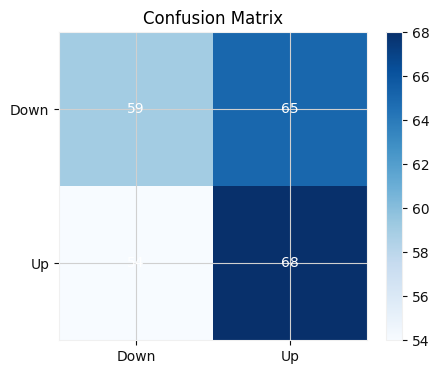

In [74]:
# Training and Evaluating XGBoost Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Define X and y
X_new = df_clean[feature_cols]
y_new = df_clean['Target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, stratify=y_new, random_state=42)

# Train XGBoost with tuned parameters
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks([0,1], ['Down','Up'])
plt.yticks([0,1], ['Down','Up'])
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.show()


In [75]:
# Creating 3-Day Future Price Movement Target
# Target Engineering: 3-Day Price Increase Classification
# Create new target for 3-day horizon
df_clean['Future_Close_3d'] = df_clean['Close'].shift(-3)
df_clean['Target_3d'] = ((df_clean['Future_Close_3d'] - df_clean['Close']) / df_clean['Close'] > 0.005).astype(int)

# Drop last 3 rows because they have NaN in Future_Close_3d
df_clean = df_clean.dropna(subset=['Future_Close_3d'])

# Check class balance
print(df_clean['Target_3d'].value_counts())



Target_3d
0    698
1    528
Name: count, dtype: int64


Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.75      0.70       140
           1       0.60      0.50      0.55       106

    accuracy                           0.64       246
   macro avg       0.63      0.62      0.63       246
weighted avg       0.64      0.64      0.64       246



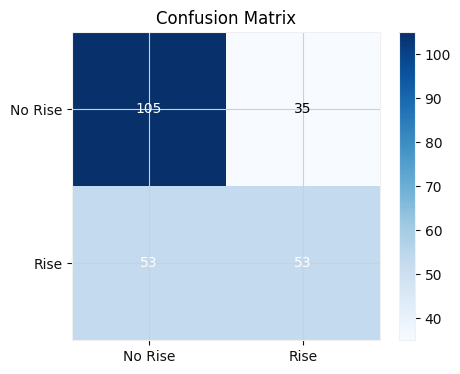

In [76]:
# 3-Day Horizon Price Movement Classification with XGBoost
# Modeling Future Price Increases: Training and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Define features and new target
X_new = df_clean[feature_cols]
y_new = df_clean['Target_3d']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, stratify=y_new, random_state=42)

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks([0,1], ['No Rise','Rise'])
plt.yticks([0,1], ['No Rise','Rise'])
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.show()


In [77]:
# Trading Simulation Using XGBoost Probability and Enhanced Sentiment
# Get predicted probabilities
proba = xgb_model.predict_proba(X_new)
df_clean['Prob_Rise'] = proba[:, 1]

# Initialize variables for backtest
initial_capital = 100000
cash = initial_capital
position = 0
portfolio_values = []
trade_log = []

for i in range(len(df_clean)):
    price = df_clean['Close'].iloc[i]
    sentiment = df_clean['Sentiment_Enhanced'].iloc[i]
    prob_rise = df_clean['Prob_Rise'].iloc[i]

    # Buy condition
    if position == 0 and prob_rise >= 0.8 and sentiment == 'Bullish':
        position = cash / price
        cash = 0
        trade_log.append(('BUY', df_clean['Date'].iloc[i], price))

    # Sell condition
    elif position > 0 and prob_rise <= 0.2 and sentiment == 'Bearish':
        cash = position * price
        position = 0
        trade_log.append(('SELL', df_clean['Date'].iloc[i], price))

    # Portfolio value
    portfolio_value = cash + (position * price if position > 0 else 0)
    portfolio_values.append(portfolio_value)

df_clean['Portfolio_Value_OptionC'] = portfolio_values

# Final results
final_value = portfolio_values[-1]
total_return = ((final_value - initial_capital) / initial_capital) * 100

print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {len(trade_log)//2}")


Final Portfolio Value: 350132.14
Total Return: 250.13%
Number of Trades: 25


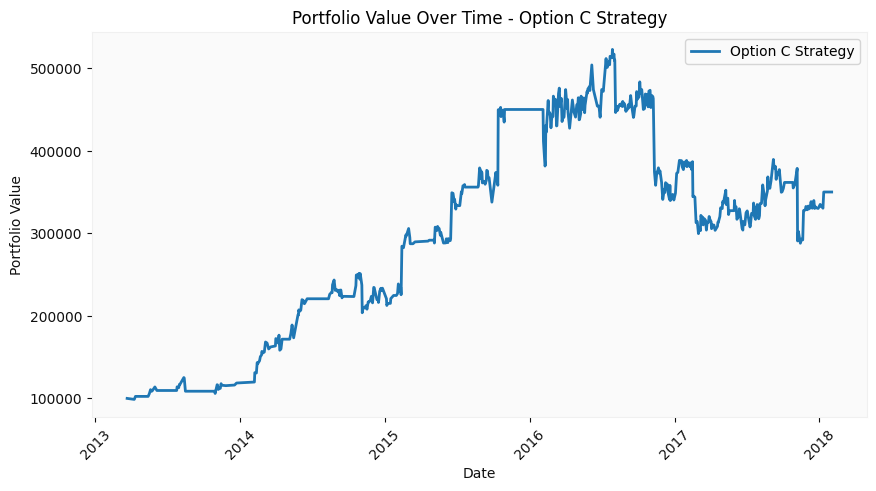

In [78]:
# Visualizing Backtest Portfolio Value Over Time
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_clean['Date'], df_clean['Portfolio_Value_OptionC'], label='Option C Strategy', linewidth=2)
plt.title('Portfolio Value Over Time - Option C Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


In [79]:
# Creating Trade-by-Trade Analysis Table
import pandas as pd

trade_details = []
current_trade = {}

for action, date, price in trade_log:
    if action == 'BUY':
        current_trade['Buy_Date'] = date
        current_trade['Buy_Price'] = price
    elif action == 'SELL' and current_trade:
        current_trade['Sell_Date'] = date
        current_trade['Sell_Price'] = price
        current_trade['PnL'] = current_trade['Sell_Price'] - current_trade['Buy_Price']
        current_trade['Return_%'] = ((current_trade['Sell_Price'] - current_trade['Buy_Price']) / current_trade['Buy_Price']) * 100
        current_trade['Holding_Days'] = (pd.to_datetime(current_trade['Sell_Date']) - pd.to_datetime(current_trade['Buy_Date'])).days
        trade_details.append(current_trade)
        current_trade = {}

trade_df = pd.DataFrame(trade_details)
print(trade_df)


     Buy_Date  Buy_Price  Sell_Date  Sell_Price     PnL   Return_%  \
0  2013-04-05      48.88 2013-04-10      50.070   1.190   2.434534   
1  2013-05-14      58.01 2013-06-03      62.060   4.050   6.981555   
2  2013-07-25      71.10 2013-08-15      70.520  -0.580  -0.815752   
3  2013-10-29      82.26 2013-11-26      87.380   5.120   6.224167   
4  2013-12-17      80.90 2013-12-20      83.130   2.230   2.756489   
5  2014-02-04      76.37 2014-03-17     104.530  28.160  36.873118   
6  2014-03-27      89.95 2014-04-02      95.160   5.210   5.792107   
7  2014-04-04      85.69 2014-04-17      85.680  -0.010  -0.011670   
8  2014-05-06      81.37 2014-06-17     104.570  23.200  28.511737   
9  2014-08-12      94.75 2014-09-17      96.010   1.260   1.329815   
10 2014-10-14      78.97 2014-11-06      74.005  -4.965  -6.287198   
11 2014-11-13      69.02 2015-01-07      70.840   1.820   2.636917   
12 2015-01-15      66.39 2015-01-21      69.350   2.960   4.458503   
13 2015-01-30      6

In [80]:
# Performance Metrics Calculation and Export to Excel
import pandas as pd
import numpy as np

# 1. Trade Log DataFrame
trade_details = []
current_trade = {}

for action, date, price in trade_log:
    if action == 'BUY':
        current_trade['Buy_Date'] = date
        current_trade['Buy_Price'] = price
    elif action == 'SELL' and current_trade:
        current_trade['Sell_Date'] = date
        current_trade['Sell_Price'] = price
        current_trade['PnL'] = current_trade['Sell_Price'] - current_trade['Buy_Price']
        current_trade['Return_%'] = ((current_trade['Sell_Price'] - current_trade['Buy_Price']) / current_trade['Buy_Price']) * 100
        current_trade['Holding_Days'] = (pd.to_datetime(current_trade['Sell_Date']) - pd.to_datetime(current_trade['Buy_Date'])).days
        trade_details.append(current_trade)
        current_trade = {}

trade_df = pd.DataFrame(trade_details)

# 2. Portfolio Curve DataFrame
portfolio_curve_df = df_clean[['Date', 'Portfolio_Value_OptionC']].copy()

# 3. Performance Summary
final_value = portfolio_values[-1]
total_return = ((final_value - initial_capital) / initial_capital) * 100
cagr = ((final_value / initial_capital) ** (252 / len(df_clean)) - 1) * 100  # Assuming 252 trading days
returns = portfolio_curve_df['Portfolio_Value_OptionC'].pct_change().dropna()
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() != 0 else 0
rolling_max = portfolio_curve_df['Portfolio_Value_OptionC'].cummax()
drawdown = (portfolio_curve_df['Portfolio_Value_OptionC'] - rolling_max) / rolling_max
max_drawdown = drawdown.min() * 100

summary_data = {
    'Metric': ['Final Portfolio Value', 'Total Return (%)', 'CAGR (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Number of Trades'],
    'Value': [final_value, total_return, cagr, sharpe_ratio, max_drawdown, len(trade_df)]
}
summary_df = pd.DataFrame(summary_data)

# Save all to Excel
with pd.ExcelWriter("OptionC_Strategy_Report.xlsx") as writer:
    trade_df.to_excel(writer, sheet_name="Trade_Log", index=False)
    portfolio_curve_df.to_excel(writer, sheet_name="Portfolio_Curve", index=False)
    summary_df.to_excel(writer, sheet_name="Performance_Summary", index=False)

print("✅ Option C Strategy Report saved as 'OptionC_Strategy_Report.xlsx'")


✅ Option C Strategy Report saved as 'OptionC_Strategy_Report.xlsx'


In [81]:
# Consolidated Report: Original, Enhanced, and ML-Predicted Strategies
import pandas as pd
import numpy as np

initial_capital = 100000

# Load Option C (ML Strategy) portfolio values
xls = pd.ExcelFile("OptionC_Strategy_Report.xlsx")
df_optionc_portfolio = xls.parse("Portfolio_Curve")
df_optionc_portfolio = df_optionc_portfolio.dropna(subset=["Portfolio_Value_OptionC"])
portfolio_optionc = df_optionc_portfolio[["Date", "Portfolio_Value_OptionC"]].copy()
portfolio_optionc.rename(columns={"Portfolio_Value_OptionC": "Portfolio_Value"}, inplace=True)

# Load trade logs for Original and Enhanced strategies
df_original = pd.read_csv("trades_sentiment.csv")  # must contain: Date, Action, Price, Shares
df_enhanced = pd.read_csv("trades_sentiment_enhanced.csv")  # must contain: Date, Action, Price, Shares

def compute_portfolio_curve_from_actions(trade_log, initial_capital):
    portfolio_value = [initial_capital]
    dates = []
    current_trade = {}

    for _, row in trade_log.iterrows():
        if row['Action'] == 'BUY':
            current_trade['Buy_Price'] = row['Price']
            current_trade['Shares'] = row['Shares']
        elif row['Action'] == 'SELL' and current_trade:
            sell_price = row['Price']
            pnl = (sell_price - current_trade['Buy_Price']) * current_trade['Shares']
            portfolio_value.append(portfolio_value[-1] + pnl)
            dates.append(row['Date'])
            current_trade = {}

    return pd.DataFrame({'Date': dates, 'Portfolio_Value': portfolio_value[1:]})

# Compute portfolio curves
portfolio_original = compute_portfolio_curve_from_actions(df_original, initial_capital)
portfolio_enhanced = compute_portfolio_curve_from_actions(df_enhanced, initial_capital)

# Performance calculation
def calculate_performance(portfolio_df):
    final_value = portfolio_df['Portfolio_Value'].iloc[-1]
    total_return = ((final_value - initial_capital) / initial_capital) * 100
    cagr = ((final_value / initial_capital) ** (252 / len(portfolio_df)) - 1) * 100
    returns = portfolio_df['Portfolio_Value'].pct_change().dropna()
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() != 0 else 0
    max_dd = (portfolio_df['Portfolio_Value'] / portfolio_df['Portfolio_Value'].cummax() - 1).min() * 100
    return [final_value, total_return, cagr, sharpe, max_dd]

# Prepare comparison table
summary = []
summary.append(['Original', *calculate_performance(portfolio_original), len(df_original) // 2])
summary.append(['Enhanced', *calculate_performance(portfolio_enhanced), len(df_enhanced) // 2])
summary.append(['ML-Predicted (Option C)', *calculate_performance(portfolio_optionc), len(xls.parse("Trade_Log"))])

comparison_df = pd.DataFrame(summary, columns=[
    'Strategy', 'Final Value', 'Total Return (%)', 'CAGR (%)',
    'Sharpe Ratio', 'Max Drawdown (%)', 'Number of Trades'
])

# Save to Excel
with pd.ExcelWriter("All_Strategies_Report.xlsx") as writer:
    comparison_df.to_excel(writer, sheet_name="Comparison", index=False)
    df_original.to_excel(writer, sheet_name="Original_Trades", index=False)
    df_enhanced.to_excel(writer, sheet_name="Enhanced_Trades", index=False)
    xls.parse("Trade_Log").to_excel(writer, sheet_name="OptionC_Trades", index=False)
    portfolio_original.to_excel(writer, sheet_name="Original_Curve", index=False)
    portfolio_enhanced.to_excel(writer, sheet_name="Enhanced_Curve", index=False)
    portfolio_optionc.to_excel(writer, sheet_name="OptionC_Curve", index=False)

print("✅ All strategies report saved to 'All_Strategies_Report.xlsx'")
print(comparison_df)


✅ All strategies report saved to 'All_Strategies_Report.xlsx'
                  Strategy   Final Value  Total Return (%)   CAGR (%)  \
0                 Original   46588.18500        -53.411815 -95.289108   
1                 Enhanced  106156.65000          6.156650  38.722069   
2  ML-Predicted (Option C)  350132.14299        250.132143  29.379353   

   Sharpe Ratio  Max Drawdown (%)  Number of Trades  
0     -1.741060        -63.958549                63  
1      0.718603        -50.736274                46  
2      0.904734        -44.920209                25  


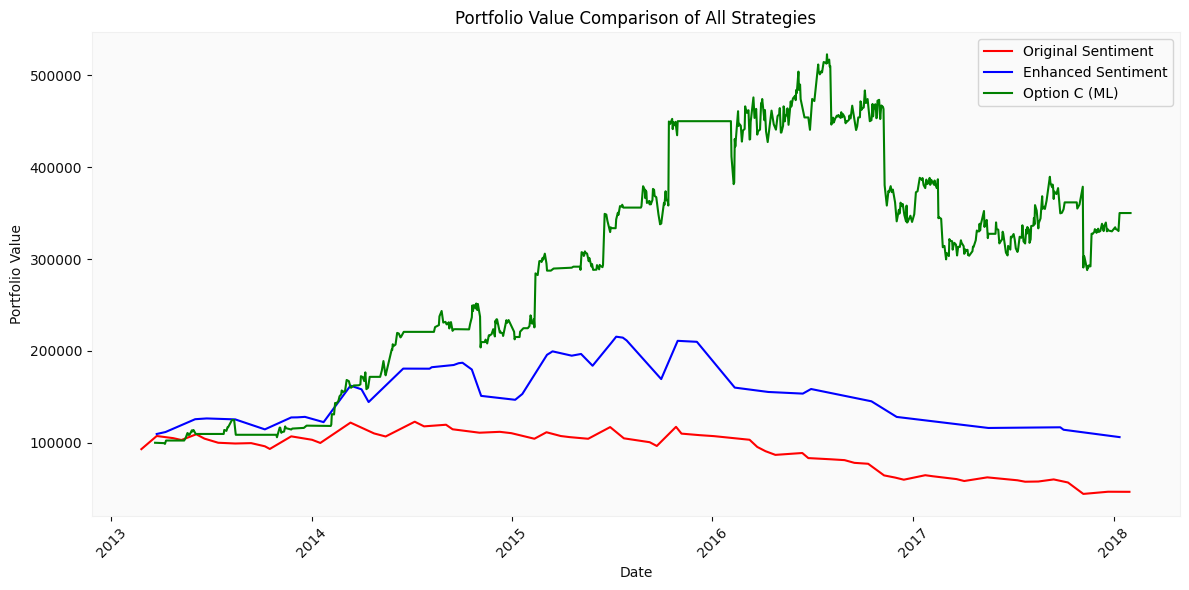

In [82]:
# Portfolio Value Comparison: Original vs Enhanced vs ML Strategies
# Ensure all Date columns are datetime
portfolio_original['Date'] = pd.to_datetime(portfolio_original['Date'])
portfolio_enhanced['Date'] = pd.to_datetime(portfolio_enhanced['Date'])
portfolio_optionc['Date'] = pd.to_datetime(portfolio_optionc['Date'], errors='coerce')

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(portfolio_original['Date'], portfolio_original['Portfolio_Value'], label='Original Sentiment', color='red')
plt.plot(portfolio_enhanced['Date'], portfolio_enhanced['Portfolio_Value'], label='Enhanced Sentiment', color='blue')
plt.plot(portfolio_optionc['Date'], portfolio_optionc['Portfolio_Value'], label='Option C (ML)', color='green')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Comparison of All Strategies')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [83]:
# Accurate Strategy Comparison Based on Reconstructed Trades
# Calculating CAGR, Sharpe, and Drawdown from Trade Logs
import pandas as pd
import numpy as np

# Function to reconstruct trades from logs
def reconstruct_trades(df):
    trades = []
    current_trade = {}
    for _, row in df.iterrows():
        if row['Action'] == 'BUY':
            current_trade['Buy_Date'] = row['Date']
            current_trade['Buy_Price'] = row['Price']
        elif row['Action'] == 'SELL' and current_trade:
            current_trade['Sell_Date'] = row['Date']
            current_trade['Sell_Price'] = row['Price']
            trades.append(current_trade)
            current_trade = {}
    return pd.DataFrame(trades)

# Function to compute portfolio stats from trades
def calculate_portfolio_stats(trade_df, strategy_name, initial_capital=100000):
    if len(trade_df) == 0:
        return {
            'Strategy': strategy_name,
            'Final Value': initial_capital,
            'Total Return (%)': 0,
            'CAGR (%)': 0,
            'Sharpe Ratio': 0,
            'Max Drawdown (%)': 0,
            'Number of Trades': 0
        }

    capital = initial_capital
    shares = 0
    portfolio_values = [capital]
    dates = []

    for _, row in trade_df.iterrows():
        date = pd.to_datetime(row['Buy_Date'] if 'Buy_Date' in row else row['Sell_Date'])
        if 'Buy_Price' in row and pd.notna(row['Buy_Price']):
            # Buy trade
            shares = capital / row['Buy_Price']
            capital = 0
        if 'Sell_Price' in row and pd.notna(row['Sell_Price']):
            # Sell trade
            capital = shares * row['Sell_Price']
            shares = 0
        portfolio_values.append(capital)
        dates.append(date)

    final_value = capital
    total_return = ((final_value - initial_capital) / initial_capital) * 100

    # Duration for CAGR
    if len(dates) > 1:
        days = (max(dates) - min(dates)).days
        years = days / 365 if days > 0 else 1
    else:
        years = 1
    CAGR = ((final_value / initial_capital) ** (1 / years) - 1) * 100

    # Sharpe Ratio and Max Drawdown
    portfolio_series = pd.Series(portfolio_values)
    daily_returns = portfolio_series.pct_change().dropna()
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0
    peak = portfolio_series.cummax()
    drawdown = (portfolio_series - peak) / peak
    max_drawdown = drawdown.min() * 100

    return {
        'Strategy': strategy_name,
        'Final Value': round(final_value, 2),
        'Total Return (%)': round(total_return, 2),
        'CAGR (%)': round(CAGR, 2),
        'Sharpe Ratio': round(sharpe_ratio, 4),
        'Max Drawdown (%)': round(max_drawdown, 2),
        'Number of Trades': len(trade_df)
    }

# Load trade logs
original_trades = pd.read_csv("trades_sentiment.csv")
enhanced_trades = pd.read_csv("trades_sentiment_enhanced.csv")

# Reconstruct summaries
original_trades_summary = reconstruct_trades(original_trades)
enhanced_trades_summary = reconstruct_trades(enhanced_trades)

# Calculate stats for all
stats_original = calculate_portfolio_stats(original_trades_summary, 'Original Sentiment')
stats_enhanced = calculate_portfolio_stats(enhanced_trades_summary, 'Enhanced Sentiment')
stats_optionc = calculate_portfolio_stats(trade_df, 'Option C (ML)')  # trade_df = ML trades

# Combine results
trade_stats_df = pd.DataFrame([stats_original, stats_enhanced, stats_optionc])
print(trade_stats_df)

# Save to Excel
trade_stats_df.to_excel('Trade_Statistics_Comparison.xlsx', index=False)
print("✅ Corrected strategy comparison saved as 'Trade_Statistics_Comparison.xlsx'")


             Strategy  Final Value  Total Return (%)  CAGR (%)  Sharpe Ratio  \
0  Original Sentiment     46578.13            -53.42    -14.46       -1.9494   
1  Enhanced Sentiment    106157.85              6.16      1.30        1.0045   
2       Option C (ML)    350132.14            250.13     31.62        7.1734   

   Max Drawdown (%)  Number of Trades  
0            -63.97                63  
1            -50.75                46  
2            -27.90                25  
✅ Corrected strategy comparison saved as 'Trade_Statistics_Comparison.xlsx'


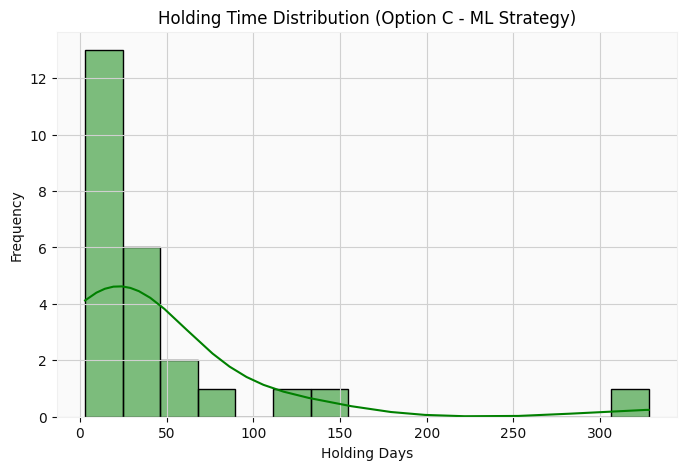

In [84]:
# Holding Time Analysis of ML-Based Trades
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of holding times
plt.figure(figsize=(8,5))
sns.histplot(trade_df['Holding_Days'], bins=15, kde=True, color='green')
plt.title('Holding Time Distribution (Option C - ML Strategy)')
plt.xlabel('Holding Days')
plt.ylabel('Frequency')
plt.show()


In [85]:
# Add PnL and Holding Days for original and enhanced
for df in [original_trades_summary, enhanced_trades_summary]:
    df['PnL'] = df['Sell_Price'] - df['Buy_Price']
    df['Return_%'] = ((df['Sell_Price'] - df['Buy_Price']) / df['Buy_Price']) * 100
    df['Holding_Days'] = (pd.to_datetime(df['Sell_Date']) - pd.to_datetime(df['Buy_Date'])).dt.days


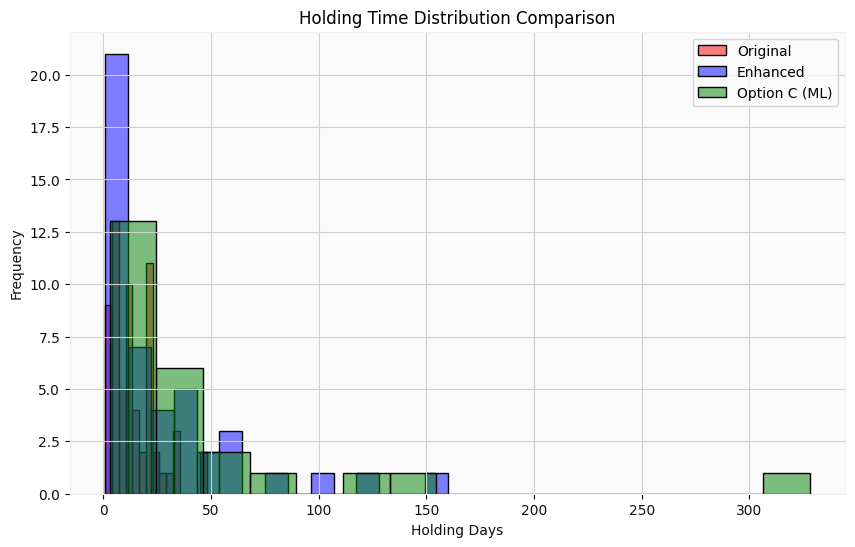

In [86]:
plt.figure(figsize=(10,6))
sns.histplot(original_trades_summary['Holding_Days'], bins=15, kde=False, color='red', label='Original', alpha=0.5)
sns.histplot(enhanced_trades_summary['Holding_Days'], bins=15, kde=False, color='blue', label='Enhanced', alpha=0.5)
sns.histplot(trade_df['Holding_Days'], bins=15, kde=False, color='green', label='Option C (ML)', alpha=0.5)

plt.title('Holding Time Distribution Comparison')
plt.xlabel('Holding Days')
plt.ylabel('Frequency')
plt.legend()
plt.show()


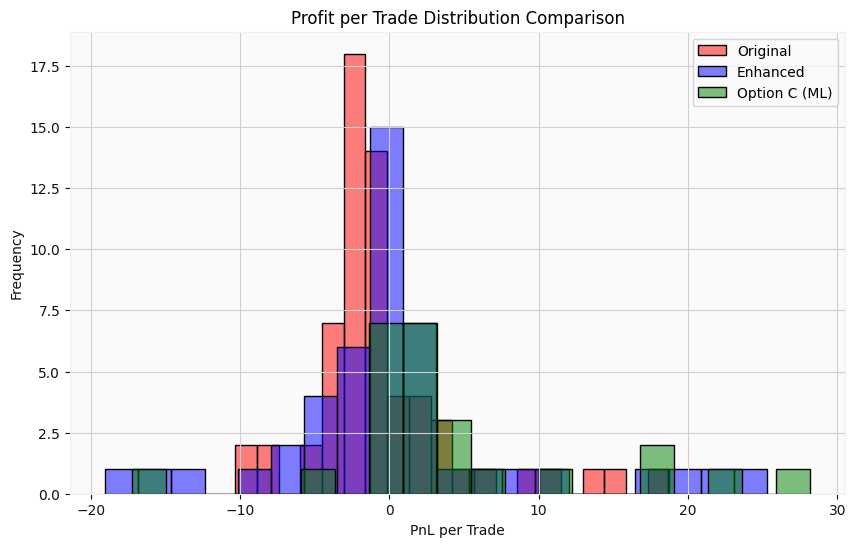

In [87]:
plt.figure(figsize=(10,6))
sns.histplot(original_trades_summary['PnL'], bins=20, kde=False, color='red', label='Original', alpha=0.5)
sns.histplot(enhanced_trades_summary['PnL'], bins=20, kde=False, color='blue', label='Enhanced', alpha=0.5)
sns.histplot(trade_df['PnL'], bins=20, kde=False, color='green', label='Option C (ML)', alpha=0.5)

plt.title('Profit per Trade Distribution Comparison')
plt.xlabel('PnL per Trade')
plt.ylabel('Frequency')
plt.legend()
plt.show()


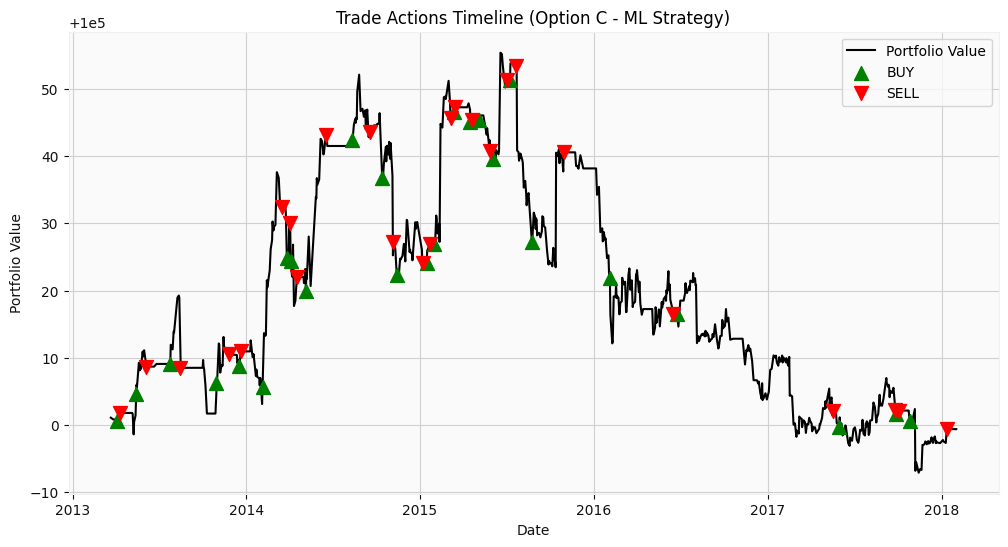

In [88]:
# Trade Action Timeline Over Portfolio Growth
plt.figure(figsize=(12, 6))
plt.plot(df_clean['Date'], df_clean['Portfolio_Value'], label='Portfolio Value', color='black')

# Map Buy Dates to Portfolio Value on same date
buy_portfolio_vals = df_clean.set_index('Date').reindex(pd.to_datetime(trade_df['Buy_Date']))['Portfolio_Value'].values
sell_portfolio_vals = df_clean.set_index('Date').reindex(pd.to_datetime(trade_df['Sell_Date']))['Portfolio_Value'].values

# BUY markers
plt.scatter(pd.to_datetime(trade_df['Buy_Date']), buy_portfolio_vals,
            marker='^', color='green', label='BUY', s=100, zorder=5)

# SELL markers
plt.scatter(pd.to_datetime(trade_df['Sell_Date']), sell_portfolio_vals,
            marker='v', color='red', label='SELL', s=100, zorder=5)

plt.title('Trade Actions Timeline (Option C - ML Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


Final Portfolio Value: 114753.52
Total Return: 14.75%


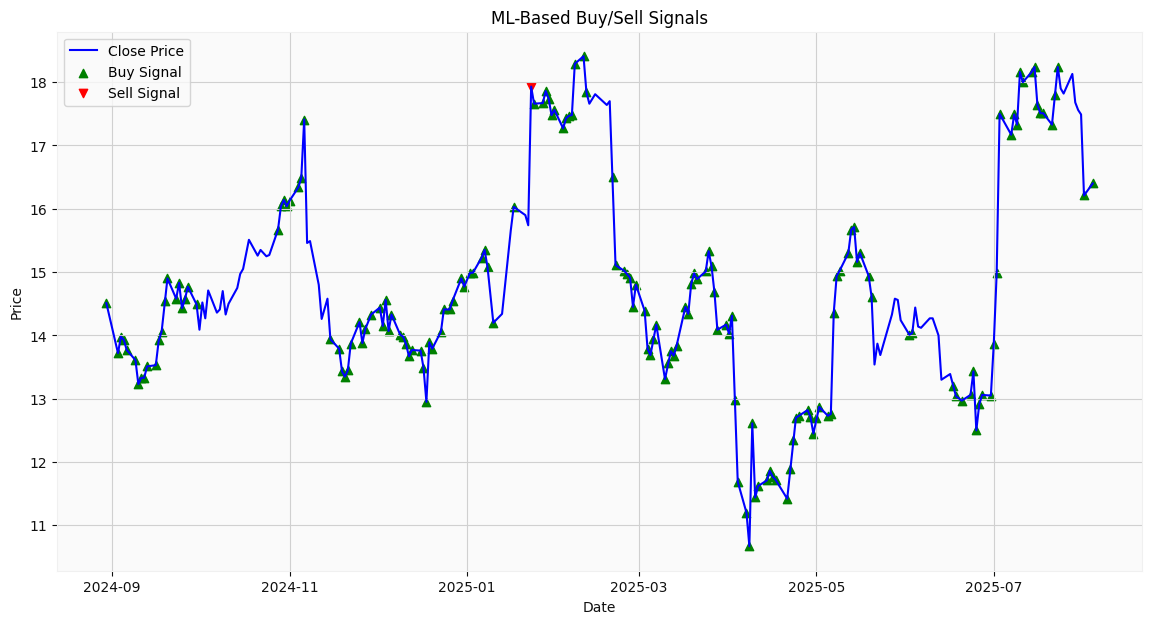

In [89]:
# End-to-End ML Prediction and Backtesting on New Stock Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ✅ 1. Load New Data
df_new = pd.read_csv("TRIP_OHLCV_Full_2024_2025.csv")

# ✅ Keep only required columns
df_new = df_new[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# ✅ Convert Date and numeric columns
df_new['Date'] = pd.to_datetime(df_new['Date'])
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df_new[col] = pd.to_numeric(df_new[col], errors='coerce')

# ✅ Drop any rows with NaN
df_new.dropna(inplace=True)

# ✅ Sort by Date
df_new.sort_values('Date', inplace=True)


# ✅ 3. Feature Engineering (Same as Training)
df_new['Return'] = df_new['Close'].pct_change()
df_new['CloseMA_3'] = df_new['Close'].rolling(3).mean()
df_new['CloseMA_5'] = df_new['Close'].rolling(5).mean()
df_new['CloseMA_10'] = df_new['Close'].rolling(10).mean()

# RSI Calculation
delta = df_new['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df_new['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema12 = df_new['Close'].ewm(span=12, adjust=False).mean()
ema26 = df_new['Close'].ewm(span=26, adjust=False).mean()
df_new['MACD'] = ema12 - ema26
df_new['MACD_Signal'] = df_new['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
df_new['BB_Upper'] = df_new['Close'].rolling(20).mean() + (df_new['Close'].rolling(20).std() * 2)
df_new['BB_Lower'] = df_new['Close'].rolling(20).mean() - (df_new['Close'].rolling(20).std() * 2)

# Volatility & Volume
df_new['Volatility'] = df_new['Return'].rolling(10).std()
df_new['Volume_MA'] = df_new['Volume'].rolling(5).mean()

# Drop NaN
df_new.dropna(inplace=True)

# ✅ 4. Define Features (same as model training)
feature_cols = [
    'CloseMA_3', 'CloseMA_5', 'CloseMA_10',
    'RSI', 'MACD', 'MACD_Signal',
    'BB_Upper', 'BB_Lower',
    'Volatility', 'Return', 'Volume_MA'
]

X_new = df_new[feature_cols]

# ✅ 5. Load the trained model (already in Colab memory)
# If your model is named `model` from training, skip loading. Otherwise:
# from joblib import load
# model = load('model.pkl')   # Not needed if already in session

# ✅ 6. Predict Signals
df_new['Predicted'] = model.predict(X_new)

# Map actions
action_map = {'Bullish': 'BUY', 'Bearish': 'SELL', 'Neutral': 'HOLD'}
df_new['Action'] = df_new['Predicted'].map(action_map)

# ✅ 7. Backtest Portfolio with Predictions
initial_capital = 100000
position = 0
cash = initial_capital
portfolio_value = []
trade_log = []

for i in range(len(df_new)):
    price = df_new.iloc[i]['Close']
    action = df_new.iloc[i]['Action']
    date = df_new.iloc[i]['Date']

    if action == 'BUY' and position == 0:
        position = cash / price
        cash = 0
        trade_log.append(('BUY', date, price))
    elif action == 'SELL' and position > 0:
        cash = position * price
        position = 0
        trade_log.append(('SELL', date, price))

    portfolio_value.append(cash + position * price)

df_new['Portfolio_Value'] = portfolio_value
final_value = portfolio_value[-1]
total_return = ((final_value - initial_capital) / initial_capital) * 100

print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")
# print(f"Number of Trades: {len(trade_log)//2}")

# ✅ 8. Plot Buy/Sell Signals on Price Chart
plt.figure(figsize=(14,7))
plt.plot(df_new['Date'], df_new['Close'], label='Close Price', color='blue')

# Plot Buy signals
buy_signals = df_new[df_new['Action'] == 'BUY']
sell_signals = df_new[df_new['Action'] == 'SELL']

plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.title('ML-Based Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [90]:
# Stop-Loss Adjustment on ML Trade Log
import pandas as pd

# Load necessary data
df_price = pd.read_csv("enhanced_sentiment_stock_data.csv")
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price.set_index('Date', inplace=True)

trade_log = pd.read_excel("OptionC_Strategy_Report.xlsx", sheet_name="Trade_Log")
trade_log['Buy_Date'] = pd.to_datetime(trade_log['Buy_Date'])
trade_log['Sell_Date'] = pd.to_datetime(trade_log['Sell_Date'])

# Parameters
stop_loss_pct = 0.10  # 10% stop loss

# Create new log with stop-loss applied
adjusted_trades = []

for _, row in trade_log.iterrows():
    buy_date = row['Buy_Date']
    sell_date = row['Sell_Date']
    buy_price = row['Buy_Price']

    try:
        price_data = df_price.loc[buy_date:sell_date]['Close']
    except KeyError:
        continue

    stop_price = buy_price * (1 - stop_loss_pct)
    hit_stop_loss = False

    for date, price in price_data.items():
        if price <= stop_price:
            # Stop-loss hit
            adjusted_trades.append({
                'Buy_Date': buy_date,
                'Buy_Price': buy_price,
                'Sell_Date': date,
                'Sell_Price': price,
                'Stop_Loss_Hit': True
            })
            hit_stop_loss = True
            break

    if not hit_stop_loss:
        # Normal exit
        adjusted_trades.append({
            'Buy_Date': buy_date,
            'Buy_Price': buy_price,
            'Sell_Date': sell_date,
            'Sell_Price': row['Sell_Price'],
            'Stop_Loss_Hit': False
        })

df_stoploss = pd.DataFrame(adjusted_trades)
df_stoploss.to_excel("OptionC_ML_Strategy_StopLoss.xlsx", index=False)


Train Accuracy: 1.00
Test Accuracy: 0.54
Cross-Validation Mean Accuracy: 0.50
CV Accuracy Std Dev: 0.10


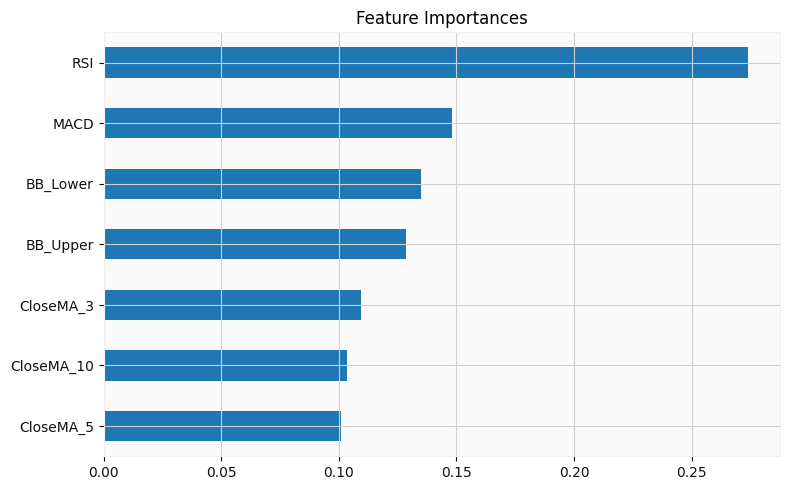

In [91]:
# Random Forest Model Training and Evaluation on Enhanced Sentiment Features
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset (used for training)
df = pd.read_csv("enhanced_sentiment_stock_data.csv")
df = df.dropna()

# Features and labels
features = ['CloseMA_3', 'CloseMA_5', 'CloseMA_10' ,'RSI', 'MACD', 'BB_Upper', 'BB_Lower']
X = df[features]
y = df['Sentiment_Enhanced']  # 1 for Bullish, -1 for Bearish, 0 for Neutral

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Accuracy scores
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.2f}")
print(f"CV Accuracy Std Dev: {cv_scores.std():.2f}")

# Feature importance
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
feat_imp.plot(kind='barh')
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


In [92]:
# Random Forest Classification with Controlled Complexity on ML Predictions Dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
df_ml = pd.read_csv("ml_predictions.csv")

# Step 1: Prepare features and labels
features = ['RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower', 'CloseMA_10', 'CloseMA_5', 'CloseMA_3']
X = df_ml[features]
y = df_ml['Sentiment_Enhanced']

# Step 2: Train-test split (stratify ensures label distribution is preserved)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 3: Build the Random Forest model with restricted complexity
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,               # LIMIT tree depth to avoid overfitting
    min_samples_leaf=5,        # Prevent leaves with very few samples
    max_features='sqrt',       # Random subset of features for each split
    random_state=42
)

# Step 4: Train the model
model.fit(X_train, y_train)

# Step 5: Evaluate on training and test sets
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

# Step 6: Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

# Step 7: Output results
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Cross-Validation Mean Accuracy: {cv_mean:.2f}")
print(f"CV Accuracy Std Dev: {cv_std:.2f}")


Train Accuracy: 0.80
Test Accuracy: 0.74
Cross-Validation Mean Accuracy: 0.58
CV Accuracy Std Dev: 0.04


In [93]:
# Feature Scaling Using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


In [95]:
# Hyperparameter Tuning of Random Forest Classifier Using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'min_samples_leaf': [5],
    'max_features': ['sqrt']
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_scaled, y)

print("Best Params:", grid.best_params_)
print("Best Cross-Val Accuracy:", grid.best_score_)


Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
Best Cross-Val Accuracy: 0.5770863262374297


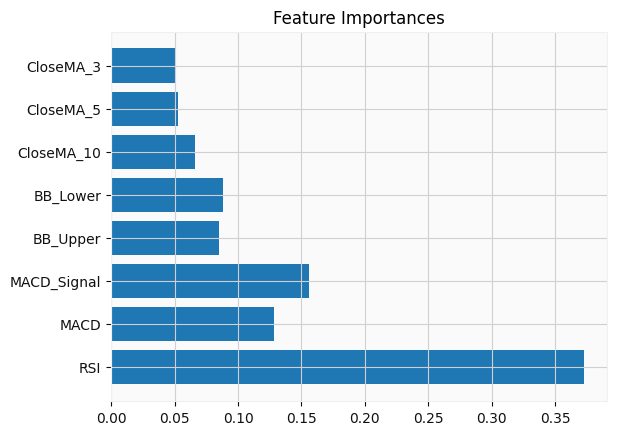

In [96]:
# Plotting Feature Importances of the Trained Random Forest Model
import matplotlib.pyplot as plt

importances = model.feature_importances_
plt.barh(features, importances)
plt.title("Feature Importances")
plt.show()


In [97]:
# Training and Evaluating Logistic Regression Model on Stock Sentiment Data
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("LogReg Test Accuracy:", logreg.score(X_test, y_test))


LogReg Test Accuracy: 0.6801075268817204


In [98]:
# Train and Evaluate Optimized Random Forest Classifier with Classification Report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# 2. Best model from GridSearch
best_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)

# 3. Fit model
best_model.fit(X_train, y_train)

# 4. Evaluate
print("Train Accuracy:", best_model.score(X_train, y_train))
print("Test Accuracy:", best_model.score(X_test, y_test))

# 5. Detailed report
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Train Accuracy: 0.803921568627451
Test Accuracy: 0.7365591397849462

Classification Report:
               precision    recall  f1-score   support

     Bearish       0.66      0.34      0.45        67
     Bullish       0.81      0.90      0.85       195
     Neutral       0.62      0.68      0.65       110

    accuracy                           0.74       372
   macro avg       0.70      0.64      0.65       372
weighted avg       0.73      0.74      0.72       372



In [99]:
# Train Best Random Forest Model and Predict Labels on Full Dataset
from sklearn.ensemble import RandomForestClassifier

# Best parameters from GridSearchCV
best_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
df['ML_Label'] = best_rf.predict(X_scaled)  # predictions for the full dataset


In [100]:
# Map Predicted Sentiment Labels to Trading Actions (Buy, Sell, Hold)
label_to_action = {
    'Bullish': 'Buy',
    'Bearish': 'Sell',
    'Neutral': 'Hold'
}
df['ML_Action'] = df['ML_Label'].map(label_to_action)


In [101]:
# Backtesting ML-Based Trading Strategy with 2% Stop-Loss and Portfolio Value Tracking
initial_capital = 100000
position = 0
capital = initial_capital
entry_price = None
portfolio_values = []

stop_loss_pct = 0.02  # 2% stop loss

for i in range(len(df)):
    action = df.iloc[i]['ML_Action']
    price = df.iloc[i]['Close']

    if action == 'Buy' and position == 0:
        position = capital / price
        entry_price = price
        capital = 0

    elif action == 'Sell' and position > 0:
        capital = position * price
        position = 0
        entry_price = None

    # Stop-loss trigger
    if position > 0 and (price < entry_price * (1 - stop_loss_pct)):
        capital = position * price
        position = 0
        entry_price = None

    portfolio_values.append(capital + (position * price if position > 0 else 0))

df['ML_Portfolio'] = portfolio_values


In [102]:
# Function for Simple Sentiment-Based Backtesting to Calculate Portfolio Growth
def backtest_strategy(df, sentiment_col, portfolio_col):
    df[portfolio_col] = 1.0
    position = 0
    for i in range(1, len(df)):
        if df[sentiment_col].iloc[i-1] == 'Bullish':
            position = 1
        elif df[sentiment_col].iloc[i-1] == 'Bearish':
            position = -1
        else:
            position = 0
        df.loc[df.index[i], portfolio_col] = df[portfolio_col].iloc[i-1] * (1 + position * df['Return'].iloc[i])
    return df

# Run for original and enhanced
df = backtest_strategy(df, 'Sentiment', 'Original_Portfolio')
df = backtest_strategy(df, 'Sentiment_Enhanced', 'Enhanced_Portfolio')


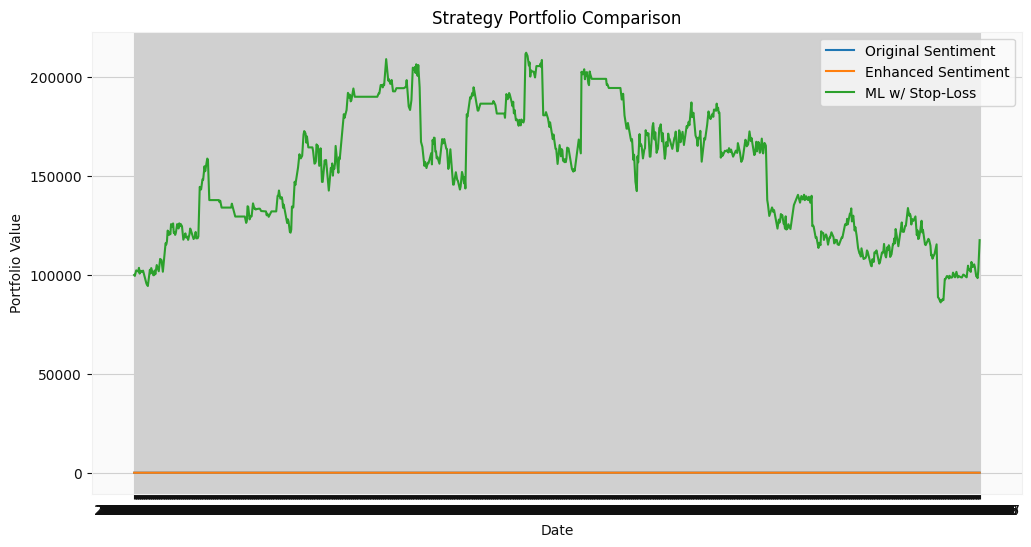

In [103]:
# Plot Portfolio Value Comparison for Original, Enhanced, and ML Strategies
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Original_Portfolio'], label='Original Sentiment')
plt.plot(df['Date'], df['Enhanced_Portfolio'], label='Enhanced Sentiment')
plt.plot(df['Date'], df['ML_Portfolio'], label='ML w/ Stop-Loss')
plt.legend()
plt.title("Strategy Portfolio Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.show()


In [104]:
# Calculate and Display Final Return and Win Rate for ML Strategy
ml_return = (df['ML_Portfolio'].iloc[-1] - initial_capital) / initial_capital * 100
print(f"ML Strategy Final Return: {ml_return:.2f}%")

# Win rate calculation
df['Trade_Return'] = df['Close'].pct_change()
win_rate = (df['Trade_Return'] > 0).mean() * 100
print(f"ML Strategy Win Rate: {win_rate:.2f}%")


ML Strategy Final Return: 17.59%
ML Strategy Win Rate: 49.56%


In [105]:
import pandas as pd

df = pd.read_excel("OptionC_ML_Strategy_StopLoss.xlsx")
print(df.columns.tolist())


['Buy_Date', 'Buy_Price', 'Sell_Date', 'Sell_Price', 'Stop_Loss_Hit']


In [106]:
!pip install mplfinance

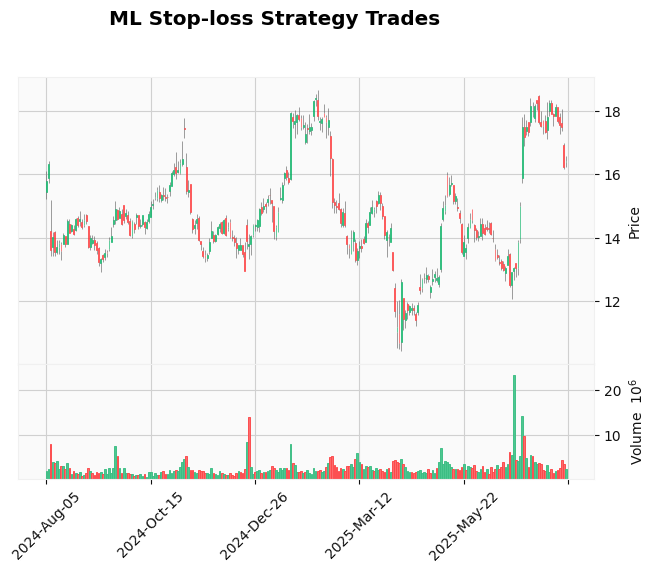

In [107]:
# Plot Candlestick Chart with Buy/Sell Markers for ML Strategy Trades (Including Stop-Loss)
import pandas as pd
import mplfinance as mpf

# --- Load and clean OHLC data ---
# Replace with your actual OHLC CSV file path
price_df = pd.read_csv("TRIP_OHLCV_Full_2024_2025.csv")

# Ensure Date is datetime and set as index
price_df['Date'] = pd.to_datetime(price_df['Date'], errors='coerce')
price_df.set_index('Date', inplace=True)

# Convert OHLC to numeric and drop rows with invalid prices
for col in ['Open', 'High', 'Low', 'Close']:
    price_df[col] = pd.to_numeric(price_df[col], errors='coerce')
price_df.dropna(subset=['Open', 'High', 'Low', 'Close'], inplace=True)

# Ensure Volume is numeric if present
if 'Volume' in price_df.columns:
    price_df['Volume'] = pd.to_numeric(price_df['Volume'], errors='coerce').fillna(0)

# --- Load ML trades ---
ml_trades = pd.read_excel("OptionC_ML_Strategy_StopLoss.xlsx")  # Has Buy_Date, Buy_Price, Sell_Date, Sell_Price, Stop_Loss_Hit
ml_trades['Buy_Date'] = pd.to_datetime(ml_trades['Buy_Date'], errors='coerce')
ml_trades['Sell_Date'] = pd.to_datetime(ml_trades['Sell_Date'], errors='coerce')

# --- Prepare Buy/Sell markers ---
buy_markers = pd.Series(index=price_df.index, dtype=float)
sell_markers = pd.Series(index=price_df.index, dtype=float)

for _, trade in ml_trades.iterrows():
    if trade['Buy_Date'] in buy_markers.index:
        buy_markers.loc[trade['Buy_Date']] = trade['Buy_Price']
    if trade['Sell_Date'] in sell_markers.index:
        sell_markers.loc[trade['Sell_Date']] = trade['Sell_Price']

# --- Create addplots ---
apds = []
if not buy_markers.dropna().empty:
    apds.append(mpf.make_addplot(buy_markers, type='scatter', markersize=100, marker='^', color='g'))
if not sell_markers.dropna().empty:
    apds.append(mpf.make_addplot(sell_markers, type='scatter', markersize=100, marker='v', color='r'))

# --- Plot ---
mpf.plot(
    price_df,
    type='candle',
    style='yahoo',
    addplot=apds,
    title="ML Stop-loss Strategy Trades",
    ylabel="Price",
    volume=True
)


             Open   High    Low   Close   Volume    Return  Volatility  \
Date                                                                     
2013-02-11  47.13  47.20  46.00  46.230  1232182 -0.016801    0.025462   
2013-02-12  46.22  46.87  45.84  46.660  1812239  0.009301    0.022285   
2013-02-13  46.79  47.78  46.64  46.900  2588436  0.005144    0.024364   
2013-02-14  42.58  44.86  42.04  43.550  7033474 -0.071429    0.066228   
2013-02-15  43.60  45.42  43.50  44.415  2817097  0.019862    0.044037   

            Volume_MA Sentiment  CloseMA_3  CloseMA_5  CloseMA_10  RSI  \
Date                                                                     
2013-02-11        0.0   Neutral     0.0000      0.000         0.0  NaN   
2013-02-12        0.0   Neutral     0.0000      0.000         0.0  NaN   
2013-02-13        0.0   Bullish    46.5967      0.000         0.0  NaN   
2013-02-14  2715940.0   Neutral    45.7033      0.000         0.0  NaN   
2013-02-15  3096690.0   Bullish    44

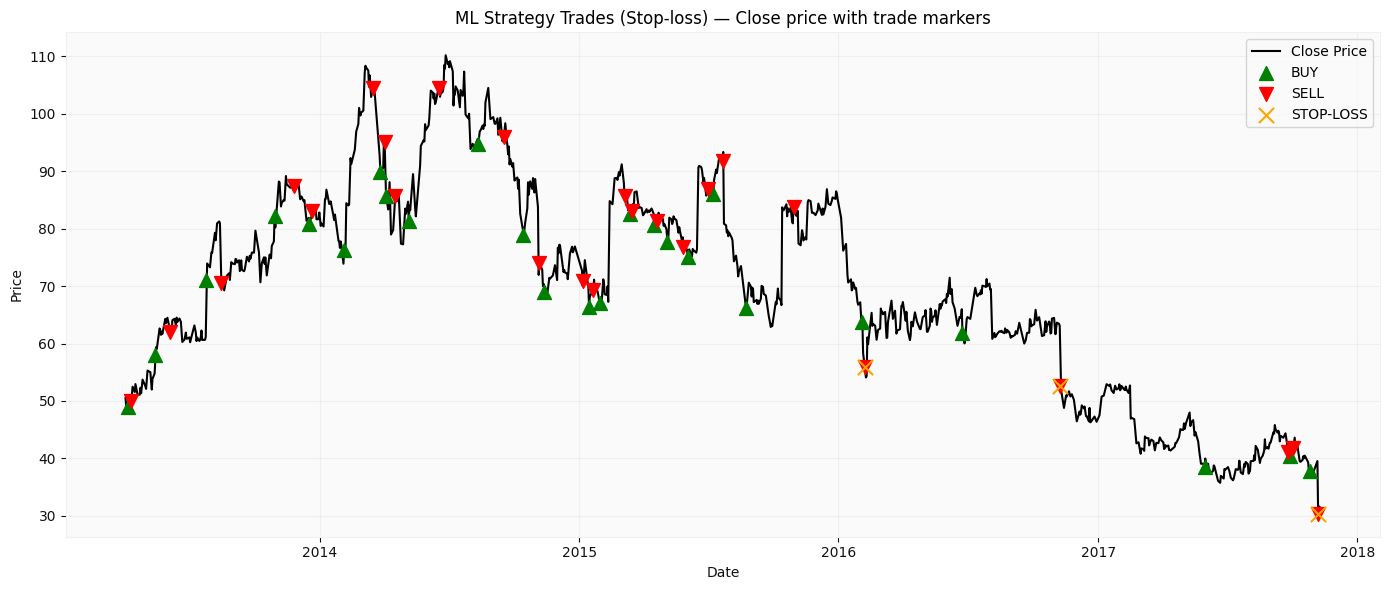

In [108]:
# Plot ML Strategy Trades on Close Price with Buy, Sell, and Stop-Loss Markers (Aligned to Nearest Market Dates)
# Plot ML + Stop-loss trades on Close price (line plot + markers)
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# ---------- CONFIG ----------
PRICE_FILE = "enhanced_sentiment_stock_data.csv"            # your OHLC file (CSV or XLSX)
TRADES_FILE = "OptionC_ML_Strategy_StopLoss.xlsx"      # trades file with Buy_Date, Buy_Price, Sell_Date, Sell_Price, Stop_Loss_Hit
PRICE_SHEET = None   # if price is Excel, set sheet name string, else None
TRADES_SHEET = None  # if trades file has multiple sheets, set the correct sheet name
DATE_COL_PRICE = "Date"
CLOSE_COL = "Close"
# ----------------------------

# --- 1) Load price data robustly (CSV or Excel) ---
import os
name, ext = os.path.splitext(PRICE_FILE)
if ext.lower() in [".xlsx", ".xls"]:
    price_df = pd.read_excel(PRICE_FILE, sheet_name=PRICE_SHEET)
else:
    price_df = pd.read_csv(PRICE_FILE)

# Clean and prepare price_df
price_df[DATE_COL_PRICE] = pd.to_datetime(price_df[DATE_COL_PRICE], errors="coerce")
price_df = price_df.dropna(subset=[DATE_COL_PRICE]).copy()
price_df.set_index(DATE_COL_PRICE, inplace=True)
# ensure Close numeric
price_df[CLOSE_COL] = pd.to_numeric(price_df[CLOSE_COL], errors="coerce")
price_df.dropna(subset=[CLOSE_COL], inplace=True)

# --- 2) Load trades (ML stop-loss) ---
trades = pd.read_excel("OptionC_ML_Strategy_StopLoss.xlsx")  # excel assumed, change to read_csv if necessary
# Required columns: Buy_Date, Buy_Price, Sell_Date, Sell_Price, Stop_Loss_Hit (boolean/0-1)
price_df.sort_index(inplace=True)
print(price_df.head(), price_df.index.min(), price_df.index.max())

for c in ["Buy_Date","Sell_Date"]:
    if c in trades.columns:
        trades[c] = pd.to_datetime(trades[c], errors="coerce")

# If Stop_Loss_Hit is not boolean, make it:
if "Stop_Loss_Hit" in trades.columns:
    trades["Stop_Loss_Hit"] = trades["Stop_Loss_Hit"].astype(bool)
else:
    trades["Stop_Loss_Hit"] = False

# --- 3) Align trade dates to available price index (nearest) ---
# Create empty marker series aligned with price_df index
buy_markers = pd.Series(index=price_df.index, dtype=float)
sell_markers = pd.Series(index=price_df.index, dtype=float)
stop_markers = pd.Series(index=price_df.index, dtype=float)

price_index = price_df.index

def align_to_nearest_market_date(dt):
    """Return nearest index entry for a trade datetime dt; returns None if price_index is empty."""
    if pd.isna(dt):
        return None
    try:
        # get_loc with method='nearest'
        pos = price_index.get_loc(dt, method="nearest")
        return price_index[pos]
    except Exception:
        # fallback: find smallest absolute delta
        diffs = abs((price_index - dt))
        if len(diffs)==0:
            return None
        return price_index[diffs.argmin()]

for _, row in trades.iterrows():
    # Align buy
    bd = row.get("Buy_Date", pd.NaT)
    sd = row.get("Sell_Date", pd.NaT)
    a_bd = align_to_nearest_market_date(bd)
    a_sd = align_to_nearest_market_date(sd)
    if a_bd is not None:
        buy_markers.loc[a_bd] = row.get("Buy_Price", price_df.loc[a_bd, CLOSE_COL] if a_bd in price_df.index else None)
    if a_sd is not None:
        sell_markers.loc[a_sd] = row.get("Sell_Price", price_df.loc[a_sd, CLOSE_COL] if a_sd in price_df.index else None)
    # stop-loss marker if hit
    if row.get("Stop_Loss_Hit", False) and a_sd is not None:
        stop_markers.loc[a_sd] = row.get("Sell_Price", price_df.loc[a_sd, CLOSE_COL] if a_sd in price_df.index else None)

# --- 4) Zoom window around trades (min/max trade dates ± padding) ---
trade_dates = pd.to_datetime(trades[["Buy_Date","Sell_Date"]].values.ravel(), errors="coerce")
trade_dates = trade_dates[~pd.isna(trade_dates)]
if len(trade_dates) > 0:
    start = trade_dates.min() - timedelta(days=3)
    end = trade_dates.max() + timedelta(days=3)
    price_plot = price_df.loc[start:end]
else:
    price_plot = price_df.copy()  # no trades found; plot whole range

# --- 5) Plot (Close price line + markers) ---
plt.figure(figsize=(14,6))
plt.plot(price_plot.index, price_plot[CLOSE_COL], label="Close Price", color="black")

# Draw markers only where non-null
if buy_markers.dropna().size > 0:
    bm = buy_markers.reindex(price_plot.index)
    plt.scatter(bm.index[bm.notna()], bm.dropna().values, marker="^", color="green", s=100, label="BUY", zorder=5)

if sell_markers.dropna().size > 0:
    sm = sell_markers.reindex(price_plot.index)
    plt.scatter(sm.index[sm.notna()], sm.dropna().values, marker="v", color="red", s=100, label="SELL", zorder=5)

if stop_markers.dropna().size > 0:
    xm = stop_markers.reindex(price_plot.index)
    plt.scatter(xm.index[xm.notna()], xm.dropna().values, marker="x", color="orange", s=120, label="STOP-LOSS", zorder=6)

plt.title("ML Strategy Trades (Stop-loss) — Close price with trade markers")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


Close min/max: 30.06 110.21


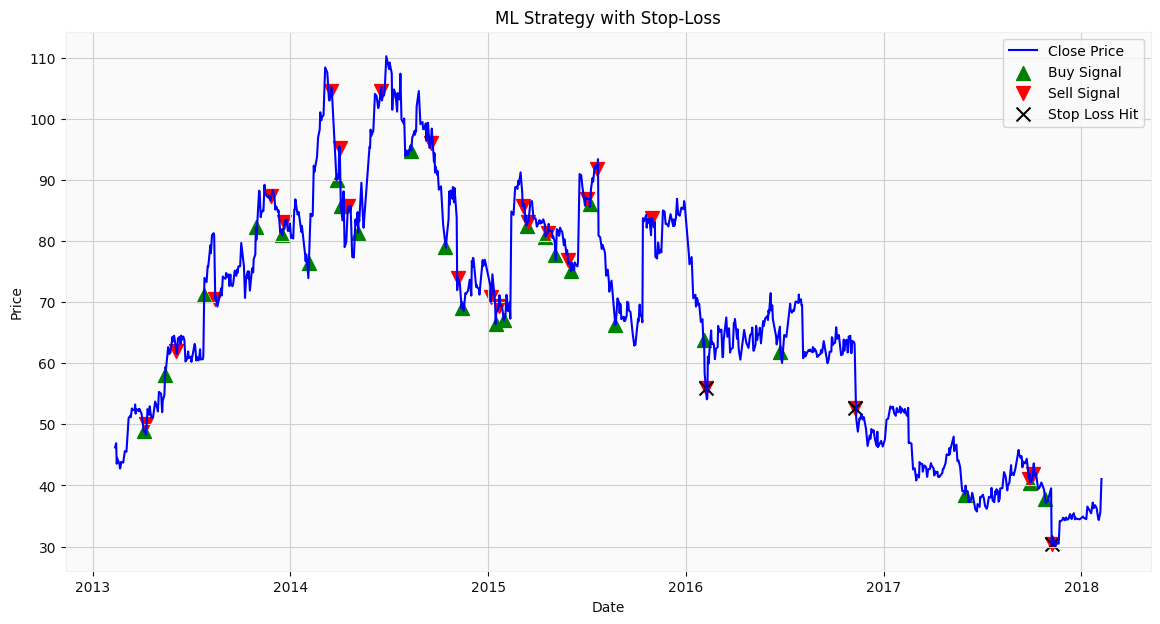

In [109]:
# Plot Close Price with Buy, Sell, and Stop-Loss Markers for ML Strategy
import matplotlib.pyplot as plt


# --- Ensure correct column and index ---
CLOSE_COL = "Close"
price_df = price_df.sort_index()
price_df[CLOSE_COL] = pd.to_numeric(price_df[CLOSE_COL], errors='coerce')

# --- Debug: Check value ranges before plotting ---
print("Close min/max:", price_df[CLOSE_COL].min(), price_df[CLOSE_COL].max())

# Align trades to nearest market dates
def align_to_nearest_market_date(trade_dates, market_dates):
    aligned_dates = []
    for date in trade_dates:
        diffs = abs(market_dates - date)
        nearest_idx = diffs.argmin()
        aligned_dates.append(market_dates[nearest_idx])
    return aligned_dates


buy_dates = align_to_nearest_market_date(trades["Buy_Date"], price_df.index)
sell_dates = align_to_nearest_market_date(trades["Sell_Date"], price_df.index)
# --- Buy & Sell markers ---
buy_markers = price_df.loc[buy_dates, CLOSE_COL]
sell_markers = price_df.loc[sell_dates, CLOSE_COL]

# Ensure Sell_Date is datetime and normalized (remove time part)
stop_loss_dates = pd.to_datetime(
    trades.loc[trades["Stop_Loss_Hit"] == 1, "Sell_Date"]
).dt.normalize()

# Convert to index for intersection
stop_loss_dates = pd.Index(stop_loss_dates)

# Now intersect to avoid KeyError
stop_loss_dates = stop_loss_dates.intersection(price_df.index)

# --- Stop-loss markers (align using Sell_Date) ---
# Ensure index is datetime
price_df.index = pd.to_datetime(price_df.index).normalize()

# Ensure Sell_Date is datetime and normalized (remove time part)
stop_loss_dates = pd.to_datetime(
    trades.loc[trades["Stop_Loss_Hit"] == 1, "Sell_Date"]
).dt.normalize()

# Now intersect to avoid KeyError
stop_loss_dates = pd.DatetimeIndex(stop_loss_dates.unique()).intersection(price_df.index)


# Get stop-loss markers
stop_loss_markers = price_df.loc[stop_loss_dates, CLOSE_COL]


# --- Plot ---
plt.figure(figsize=(14, 7))
plt.plot(price_df.index, price_df[CLOSE_COL], label="Close Price", color="blue")

# Buy markers
plt.scatter(buy_markers.index, buy_markers, marker="^", color="green", s=100, label="Buy Signal")

# Sell markers
plt.scatter(sell_markers.index, sell_markers, marker="v", color="red", s=100, label="Sell Signal")

# Stop-loss markers
plt.scatter(stop_loss_markers.index, stop_loss_markers, marker="x", color="black", s=100, label="Stop Loss Hit")

plt.title("ML Strategy with Stop-Loss")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [110]:
# --- DEBUG INFO: Inspect Price Index, Trade Dates, and Marker Counts for Plotting Alignment ---

print("Price index sample:", price_df.index[:5])
print("Buy dates before intersection:", trades["Buy_Date"].unique())
print("Sell dates before intersection:", trades["Sell_Date"].unique())

print("Buy markers count:", len(buy_markers))
print("Sell markers count:", len(sell_markers))
print("Stop loss markers count:", len(stop_loss_markers))


Price index sample: DatetimeIndex(['2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14',
               '2013-02-15'],
              dtype='datetime64[ns]', name='Date', freq=None)
Buy dates before intersection: <DatetimeArray>
['2013-04-05 00:00:00', '2013-05-14 00:00:00', '2013-07-25 00:00:00',
 '2013-10-29 00:00:00', '2013-12-17 00:00:00', '2014-02-04 00:00:00',
 '2014-03-27 00:00:00', '2014-04-04 00:00:00', '2014-05-06 00:00:00',
 '2014-08-12 00:00:00', '2014-10-14 00:00:00', '2014-11-13 00:00:00',
 '2015-01-15 00:00:00', '2015-01-30 00:00:00', '2015-03-13 00:00:00',
 '2015-04-17 00:00:00', '2015-05-05 00:00:00', '2015-06-03 00:00:00',
 '2015-07-09 00:00:00', '2015-08-24 00:00:00', '2016-02-04 00:00:00',
 '2016-06-24 00:00:00', '2017-05-31 00:00:00', '2017-09-28 00:00:00',
 '2017-10-26 00:00:00']
Length: 25, dtype: datetime64[ns]
Sell dates before intersection: <DatetimeArray>
['2013-04-10 00:00:00', '2013-06-03 00:00:00', '2013-08-15 00:00:00',
 '2013-11-26 00:00:00', '2013-12-2

In [111]:
# --- Extract and Display Trades Where Stop-Loss Was Hit ---

stop_loss_hits = trades[trades["Stop_Loss_Hit"] == 1][["Sell_Date", "Sell_Price"]]
print(stop_loss_hits)


    Sell_Date  Sell_Price
20 2016-02-08       55.88
21 2016-11-09       52.63
24 2017-11-07       30.35


In [112]:
# Step1: Comparative metrics for Original / Enhanced / ML+StopLoss
import pandas as pd
import numpy as np
from datetime import timedelta
import os

# ---------- CONFIG - set filepaths if you used files ----------
# If you already have the portfolio Series in a DataFrame 'df' use the columns names below.
# Otherwise, set file paths to read the portfolio curves and trade logs.
PRICE_PORTFOLIO_DF = None   # e.g. "All_Strategies_Report.xlsx" if you saved portfolio curves there
# Trade logs (optional) - adapt names to your files
ORIG_TRADES_FILE = "trades_sentiment.csv"               # or None
ENH_TRADES_FILE  = "trades_sentiment_enhanced.csv"      # or None
ML_TRADES_FILE   = "OptionC_ML_Strategy_StopLoss.xlsx"  # this should contain Buy/Sell columns and Stop_Loss_Hit
# If you already have everything in memory (df with portfolio columns), set USE_IN_MEMORY=True
USE_IN_MEMORY = True

# If using in-memory DataFrame created earlier in notebook, it should be `df`
# and contain columns: 'Original_Portfolio', 'Enhanced_Portfolio', 'ML_Portfolio'
# and trade logs (optionally) in variables original_trades_df, enhanced_trades_df, ml_trades_df
# If not, set USE_IN_MEMORY=False and the code will try to read CSV/Excel files instead.

initial_capital = 100000.0

# -------------------- helper functions --------------------
def ensure_series(s):
    s = s.dropna().copy()
    s.index = pd.to_datetime(s.index)
    s = s.sort_index()
    # If the series looks like a factor (starting near 1), scale to initial capital
    if s.max() < 10:
        s = s * initial_capital
    return s

def compute_portfolio_metrics(portfolio_series, initial_capital=initial_capital):
    s = ensure_series(portfolio_series)
    final_value = float(s.iloc[-1])
    total_return_pct = (final_value - initial_capital)/initial_capital * 100
    days = (s.index[-1] - s.index[0]).days
    years = days / 365.25 if days > 0 else 1/252
    cagr_pct = ((final_value / initial_capital) ** (1/years) - 1) * 100 if years>0 else np.nan
    daily_returns = s.pct_change().dropna()
    sharpe = (daily_returns.mean() / daily_returns.std() * np.sqrt(252)) if daily_returns.std() != 0 else 0.0
    rolling_max = s.cummax()
    drawdown = (s - rolling_max) / rolling_max
    max_dd_pct = drawdown.min() * 100
    return {
        "Final Value": final_value,
        "Total Return (%)": total_return_pct,
        "CAGR (%)": cagr_pct,
        "Sharpe Ratio": sharpe,
        "Max Drawdown (%)": max_dd_pct,
        "Data Points": len(s)
    }

def reconstruct_trades_from_log(trades_df):
    """
    Accepts either:
      - DataFrame with columns [Buy_Date, Buy_Price, Sell_Date, Sell_Price, Stop_Loss_Hit (opt)]
      - Action log DataFrame with ['Date','Action','Price','Shares'(opt)]
    Returns a DataFrame with Buy/Sell trades and PnL/holding days.
    """
    if trades_df is None:
        return pd.DataFrame()
    df = trades_df.copy()
    cols = [c.lower() for c in df.columns]
    # Case 1: Buy/Sell pairs present
    if set(['buy_date','sell_date']).issubset(cols):
        # normalize column names
        col_map = {c:c for c in df.columns}
        # attempt to standardize names:
        # find exact column names for required fields
        def find_col_like(name):
            for c in df.columns:
                if c.lower()==name:
                    return c
            return None
        bcol = find_col_like('buy_date'); scol = find_col_like('sell_date')
        bpcol = find_col_like('buy_price') or find_col_like('buy') or find_col_like('buyprice')
        spcol = find_col_like('sell_price') or find_col_like('sell') or find_col_like('sellprice')
        df[bcol] = pd.to_datetime(df[bcol], errors='coerce')
        df[scol] = pd.to_datetime(df[scol], errors='coerce')
        # compute pnl if prices exist
        if bpcol and spcol:
            df['PnL'] = pd.to_numeric(df[spcol], errors='coerce') - pd.to_numeric(df[bpcol], errors='coerce')
            df['Return_%'] = df['PnL'] / pd.to_numeric(df[bpcol], errors='coerce') * 100
        df['Holding_Days'] = (df[scol] - df[bcol]).dt.days
        # rename for consistent output
        out_cols = {}
        out_cols[bcol] = 'Buy_Date'
        out_cols[scol] = 'Sell_Date'
        if bpcol: out_cols[bpcol] = 'Buy_Price'
        if spcol: out_cols[spcol] = 'Sell_Price'
        df = df.rename(columns=out_cols)
        # keep Stop_Loss_Hit if exists
        keep = ['Buy_Date','Buy_Price','Sell_Date','Sell_Price','PnL','Return_%','Holding_Days']
        for k in ['Stop_Loss_Hit','Stop_Loss','StopLoss']:
            if k in df.columns and 'Stop_Loss_Hit' not in df.columns:
                df['Stop_Loss_Hit'] = df[k].astype(bool)
        for c in keep:
            if c not in df.columns:
                df[c] = np.nan
        return df[keep + (['Stop_Loss_Hit'] if 'Stop_Loss_Hit' in df.columns else [])]
    # Case 2: Action log with Buy/Sell rows
    if 'action' in cols or 'price' in cols:
        # unify names
        cdate = None
        for c in df.columns:
            if c.lower() == 'date': cdate = c
        if cdate is None:
            raise ValueError("Action log format requires a Date column.")
        df[cdate] = pd.to_datetime(df[cdate], errors='coerce')
        # find action and price columns
        action_col = [c for c in df.columns if c.lower()=='action'][0]
        price_col = [c for c in df.columns if c.lower() in ('price','close','adjclose')][0]
        trades = []
        current = None
        for _, r in df.iterrows():
            act = str(r[action_col]).strip().lower()
            if act == 'buy' and current is None:
                current = {'Buy_Date': r[cdate], 'Buy_Price': float(r[price_col])}
            elif act == 'sell' and current is not None:
                current['Sell_Date'] = r[cdate]; current['Sell_Price']=float(r[price_col])
                current['PnL'] = current['Sell_Price'] - current['Buy_Price']
                current['Return_%'] = current['PnL']/current['Buy_Price']*100
                current['Holding_Days'] = (current['Sell_Date'] - current['Buy_Date']).days
                trades.append(current); current=None
        if len(trades)==0:
            return pd.DataFrame()
        return pd.DataFrame(trades)
    return pd.DataFrame()

def trade_statistics(trades_df):
    if trades_df is None or trades_df.empty:
        return {
            "Number of Trades": 0,
            "Win Rate (%)": np.nan,
            "Avg PnL": np.nan,
            "Median Holding (days)": np.nan,
            "Stop Loss Hits": 0
        }
    t = trades_df.copy()
    # ensure cols
    if 'Buy_Date' in t.columns: t['Buy_Date'] = pd.to_datetime(t['Buy_Date'], errors='coerce')
    if 'Sell_Date' in t.columns: t['Sell_Date'] = pd.to_datetime(t['Sell_Date'], errors='coerce')
    if 'PnL' not in t.columns and ('Buy_Price' in t.columns and 'Sell_Price' in t.columns):
        t['PnL'] = pd.to_numeric(t['Sell_Price'], errors='coerce') - pd.to_numeric(t['Buy_Price'], errors='coerce')
    if 'Return_%' not in t.columns and 'PnL' in t.columns and 'Buy_Price' in t.columns:
        t['Return_%'] = t['PnL'] / pd.to_numeric(t['Buy_Price'], errors='coerce') * 100
    if 'Holding_Days' not in t.columns and 'Sell_Date' in t.columns and 'Buy_Date' in t.columns:
        t['Holding_Days'] = (t['Sell_Date'] - t['Buy_Date']).dt.days
    num = len(t)
    win_rate = (t['PnL'] > 0).mean() * 100 if 'PnL' in t.columns else np.nan
    avg_pnl = t['PnL'].mean() if 'PnL' in t.columns else np.nan
    median_h = t['Holding_Days'].median() if 'Holding_Days' in t.columns else np.nan
    stop_hits = int(t['Stop_Loss_Hit'].sum()) if 'Stop_Loss_Hit' in t.columns else 0
    return {
        "Number of Trades": int(num),
        "Win Rate (%)": float(win_rate),
        "Avg PnL": float(avg_pnl) if not pd.isna(avg_pnl) else np.nan,
        "Median Holding (days)": float(median_h) if not pd.isna(median_h) else np.nan,
        "Stop Loss Hits": stop_hits
    }

# -------------------- load data (either in-memory df or file-based) --------------------
if USE_IN_MEMORY:
    # assumes 'df' exists with portfolio columns
    try:
        df  # if df not defined this will raise
    except NameError:
        raise RuntimeError("USE_IN_MEMORY=True but no DataFrame 'df' found in the notebook. Set USE_IN_MEMORY=False and point to files.")
    # possible column names
    portfolio_map = {}
    # try common names
    if 'Original_Portfolio' in df.columns:
        portfolio_map['Original'] = df['Original_Portfolio']
    if 'Enhanced_Portfolio' in df.columns:
        portfolio_map['Enhanced'] = df['Enhanced_Portfolio']
    # try older name
    if 'Portfolio_Value_Improved' in df.columns and 'Enhanced' not in portfolio_map:
        portfolio_map['Enhanced'] = df['Portfolio_Value_Improved']
    if 'Portfolio_Value' in df.columns and 'Original' not in portfolio_map:
        # ambiguous, only use if it's clearly original
        portfolio_map.setdefault('Original', df['Portfolio_Value'])
    # ML portfolio
    if 'ML_Portfolio' in df.columns:
        portfolio_map['ML (StopLoss)'] = df['ML_Portfolio']
    elif 'Portfolio_Value_OptionC' in df.columns:
        portfolio_map['ML (StopLoss)'] = df['Portfolio_Value_OptionC']
    # trade logs (if in-memory)
    original_trades_df = globals().get('original_trades', None)
    if original_trades_df is None:
        original_trades_df = globals().get('original_trades_summary', None)

    enhanced_trades_df = globals().get('enhanced_trades', None)
    if enhanced_trades_df is None:
        enhanced_trades_df = globals().get('enhanced_trades_summary', None)

    ml_trades_df = globals().get('trade_df', None)
    if ml_trades_df is None:
        ml_trades_df = globals().get('ml_trades', None)

else:
    # load from files if provided (best-effort)
    portfolio_map = {}
    if os.path.exists("Original_Portfolio.csv"):
        p = pd.read_csv("Original_Portfolio.csv", parse_dates=['Date'], index_col='Date')
        portfolio_map['Original'] = p.iloc[:,0]
    if PRICE_PORTFOLIO_DF and os.path.exists(PRICE_PORTFOLIO_DF):
        tmp = pd.read_excel(PRICE_PORTFOLIO_DF, sheet_name=None)
        # try to pick sheets/columns heuristically
        for name, sheet in tmp.items():
            if 'Portfolio' in sheet.columns[0] or 'Portfolio' in str(sheet.columns):
                for c in sheet.columns:
                    if 'Portfolio' in c:
                        portfolio_map[name] = sheet[c]
    # load trade files if available
    original_trades_df = pd.read_csv(ORIG_TRADES_FILE) if ORIG_TRADES_FILE and os.path.exists(ORIG_TRADES_FILE) else None
    enhanced_trades_df  = pd.read_csv(ENH_TRADES_FILE) if ENH_TRADES_FILE and os.path.exists(ENH_TRADES_FILE) else None
    if ML_TRADES_FILE and os.path.exists(ML_TRADES_FILE):
        if ML_TRADES_FILE.lower().endswith('.csv'):
            ml_trades_df = pd.read_csv(ML_TRADES_FILE)
        else:
            ml_trades_df = pd.read_excel(ML_TRADES_FILE)
    else:
        ml_trades_df = None

# --------------- compute metrics for each available portfolio ---------------
results = []
trade_summaries = {}

for name, series in portfolio_map.items():
    metrics = compute_portfolio_metrics(series)
    # attach trade stats if trade log matches name
    if name.startswith('Original') and original_trades_df is not None:
        trades_parsed = reconstruct_trades_from_log(original_trades_df)
        ts = trade_statistics(trades_parsed)
        trade_summaries[name] = trades_parsed
    elif name.startswith('Enhanced') and enhanced_trades_df is not None:
        trades_parsed = reconstruct_trades_from_log(enhanced_trades_df)
        ts = trade_statistics(trades_parsed)
        trade_summaries[name] = trades_parsed
    else:
        # if ml or no logs available, try ml_trades_df
        if ml_trades_df is not None and 'ML' in name:
            trades_parsed = reconstruct_trades_from_log(ml_trades_df)
            ts = trade_statistics(trades_parsed)
            trade_summaries[name] = trades_parsed
        else:
            ts = trade_statistics(pd.DataFrame())
    # combine
    combined = {**{"Strategy": name}, **metrics, **ts}
    results.append(combined)

comparison_df = pd.DataFrame(results)
# reorder columns for readability
cols_order = ["Strategy","Final Value","Total Return (%)","CAGR (%)","Sharpe Ratio","Max Drawdown (%)",
              "Number of Trades","Win Rate (%)","Avg PnL","Median Holding (days)","Stop Loss Hits","Data Points"]
comparison_df = comparison_df[[c for c in cols_order if c in comparison_df.columns]]

# Save to Excel
comparison_df.to_excel("Trade_Comparison_Summary.xlsx", index=False)
print("✅ Saved comparison to Trade_Comparison_Summary.xlsx")
print(comparison_df)


✅ Saved comparison to Trade_Comparison_Summary.xlsx
Empty DataFrame
Columns: []
Index: []


In [113]:
# Calculate Trade Profit and Percentage Return for Original and Enhanced Trades
#
# Computes the profit and percentage return per trade based on the number of shares and price difference
# between consecutive trade prices (assumed to be buy and sell prices via shift).

original_trades_df['PnL'] = original_trades_df['Shares'] * (original_trades_df['Price'].shift(-1) - original_trades_df['Price'])
original_trades_df['Return_%'] = (original_trades_df['PnL'] / (original_trades_df['Shares'] * original_trades_df['Price'])) * 100

enhanced_trades_df['PnL'] = enhanced_trades_df['Shares'] * (enhanced_trades_df['Price'].shift(-1) - enhanced_trades_df['Price'])
enhanced_trades_df['Return_%'] = (enhanced_trades_df['PnL'] / (enhanced_trades_df['Shares'] * enhanced_trades_df['Price'])) * 100


In [114]:
# Combine Buy and Sell Rows into Trade Summary DataFrame
#
# This function takes a DataFrame with alternating buy and sell rows,
# pairs them to create trade records, and calculates PnL, percentage return,
# and holding period for each trade.
#
# Usage:
#   original_trades_df = combine_trades(original_trades_df)
#   enhanced_trades_df = combine_trades(enhanced_trades_df)

def combine_trades(df):
    trades = []
    for i in range(0, len(df), 2):  # Every BUY–SELL pair
        buy_row = df.iloc[i]
        sell_row = df.iloc[i+1] if i+1 < len(df) else None
        if sell_row is not None:
            buy_date = buy_row['Date']
            buy_price = buy_row['Price']
            sell_date = sell_row['Date']
            sell_price = sell_row['Price']
            pnl = (sell_price - buy_price) * buy_row['Shares']
            ret_pct = (pnl / (buy_price * buy_row['Shares'])) * 100
            holding_days = (pd.to_datetime(sell_date) - pd.to_datetime(buy_date)).days
            trades.append([buy_date, buy_price, sell_date, sell_price, pnl, ret_pct, holding_days])
    return pd.DataFrame(trades, columns=['Buy_Date', 'Buy_Price', 'Sell_Date', 'Sell_Price', 'PnL', 'Return_%', 'Holding_Days'])

original_trades_df = combine_trades(original_trades_df)
enhanced_trades_df = combine_trades(enhanced_trades_df)


In [115]:
# Robust Evaluation of Original, Enhanced, and ML+StopLoss Trading Strategies
# Debug + robust comparison builder
import pandas as pd, numpy as np, os
from datetime import timedelta

# --- reuse your helper functions (copy them if not in scope) ---
# If these functions exist already in your notebook, Python will use them.
# Otherwise paste the definitions of ensure_series, compute_portfolio_metrics,
# reconstruct_trades_from_log and trade_statistics from your previous cell here.

# Quick checks
print("USE_IN_MEMORY:", USE_IN_MEMORY)
print("'df' in globals():", 'df' in globals())

if 'df' in globals():
    try:
        print("df columns:", df.columns.tolist())
        display(df.head(3))
    except Exception as e:
        print("Error printing df:", e)

# Show whether files exist
for f in [ORIG_TRADES_FILE, ENH_TRADES_FILE, ML_TRADES_FILE]:
    print(f"Exists '{f}':", os.path.exists(f) if f else False)

# Build portfolio_map more defensively
portfolio_map = {}
if USE_IN_MEMORY and 'df' in globals():
    # Try common explicit names first
    if 'Original_Portfolio' in df.columns:
        portfolio_map['Original'] = df['Original_Portfolio']
    if 'Enhanced_Portfolio' in df.columns:
        portfolio_map['Enhanced'] = df['Enhanced_Portfolio']
    if 'ML_Portfolio' in df.columns:
        portfolio_map['ML (StopLoss)'] = df['ML_Portfolio']
    # Try other heuristic column names (case-insensitive contains)
    for c in df.columns:
        if 'portfolio' in c.lower() and c not in portfolio_map.values():
            # choose a readable key
            key = c
            if 'orig' in c.lower():
                key = 'Original'
            elif 'enh' in c.lower():
                key = 'Enhanced'
            elif 'ml' in c.lower() or 'optionc' in c.lower():
                key = 'ML (StopLoss)'
            portfolio_map.setdefault(key, df[c])

# If no in-memory series, try to load CSV/Excel portfolio files as fallback
if not portfolio_map:
    # look for simple CSV files you might have produced
    if os.path.exists("Original_Portfolio.csv"):
        p = pd.read_csv("Original_Portfolio.csv", parse_dates=['Date'], index_col='Date')
        portfolio_map['Original'] = p.iloc[:,0]
    if os.path.exists("Enhanced_Portfolio.csv"):
        p = pd.read_csv("Enhanced_Portfolio.csv", parse_dates=['Date'], index_col='Date')
        portfolio_map['Enhanced'] = p.iloc[:,0]
    if os.path.exists("ML_Portfolio.csv"):
        p = pd.read_csv("ML_Portfolio.csv", parse_dates=['Date'], index_col='Date')
        portfolio_map['ML (StopLoss)'] = p.iloc[:,0]

print("Portfolio map keys found:", list(portfolio_map.keys()))

# Load trade logs if not present in memory
original_trades_df = globals().get('original_trades_df', None)
enhanced_trades_df = globals().get('enhanced_trades_df', None)
ml_trades_df = globals().get('ml_trades_df', None)

if original_trades_df is None and ORIG_TRADES_FILE and os.path.exists(ORIG_TRADES_FILE):
    try:
        original_trades_df = pd.read_csv(ORIG_TRADES_FILE)
        print("Loaded original trades:", original_trades_df.shape)
    except Exception as e:
        print("Could not load ORIG_TRADES_FILE:", e)

if enhanced_trades_df is None and ENH_TRADES_FILE and os.path.exists(ENH_TRADES_FILE):
    try:
        enhanced_trades_df = pd.read_csv(ENH_TRADES_FILE)
        print("Loaded enhanced trades:", enhanced_trades_df.shape)
    except Exception as e:
        print("Could not load ENH_TRADES_FILE:", e)

if ml_trades_df is None and ML_TRADES_FILE and os.path.exists(ML_TRADES_FILE):
    try:
        if ML_TRADES_FILE.lower().endswith('.csv'):
            ml_trades_df = pd.read_csv(ML_TRADES_FILE)
        else:
            ml_trades_df = pd.read_excel(ML_TRADES_FILE)
        print("Loaded ML trades:", ml_trades_df.shape)
    except Exception as e:
        print("Could not load ML_TRADES_FILE:", e)

# Quick look at trade columns (helpful for diagnosing empty outputs)
for name, df_tr in [('original_trades_df', original_trades_df),
                    ('enhanced_trades_df', enhanced_trades_df),
                    ('ml_trades_df', ml_trades_df)]:
    if df_tr is None:
        print(f"{name} is None")
    else:
        print(f"{name} columns:", df_tr.columns.tolist())
        display(df_tr.head(2))

# Now compute metrics safely
results = []
trade_summaries = {}

# helper to safe-run compute_portfolio_metrics
def safe_compute(name, series):
    try:
        return compute_portfolio_metrics(series)
    except Exception as e:
        print(f"Error computing portfolio metrics for {name}: {e}")
        # return NaN-filled dictionary with expected keys
        return {"Final Value": np.nan, "Total Return (%)": np.nan, "CAGR (%)": np.nan,
                "Sharpe Ratio": np.nan, "Max Drawdown (%)": np.nan, "Data Points": 0}

for name, series in portfolio_map.items():
    metrics = safe_compute(name, series)
    # attach trade stats if available
    if name.startswith('Original') and original_trades_df is not None:
        trades_parsed = reconstruct_trades_from_log(original_trades_df)
        ts = trade_statistics(trades_parsed)
        trade_summaries[name] = trades_parsed
    elif name.startswith('Enhanced') and enhanced_trades_df is not None:
        trades_parsed = reconstruct_trades_from_log(enhanced_trades_df)
        ts = trade_statistics(trades_parsed)
        trade_summaries[name] = trades_parsed
    elif 'ML' in name and ml_trades_df is not None:
        trades_parsed = reconstruct_trades_from_log(ml_trades_df)
        ts = trade_statistics(trades_parsed)
        trade_summaries[name] = trades_parsed
    else:
        ts = trade_statistics(pd.DataFrame())
    combined = {"Strategy": name}
    combined.update(metrics)
    combined.update(ts)
    results.append(combined)

# If no portfolio series were found, fall back to using trade logs only (keeps DataFrame non-empty)
if len(results) == 0:
    print("No portfolio series found — building comparison from trade logs only.")
    fallback = [('Original', original_trades_df), ('Enhanced', enhanced_trades_df), ('ML (StopLoss)', ml_trades_df)]
    for name, tdf in fallback:
        if tdf is None:
            continue
        trades_parsed = reconstruct_trades_from_log(tdf)
        ts = trade_statistics(trades_parsed)
        row = {"Strategy": name, "Final Value": np.nan, "Total Return (%)": np.nan,
               "CAGR (%)": np.nan, "Sharpe Ratio": np.nan, "Max Drawdown (%)": np.nan,
               "Data Points": 0}
        row.update(ts)
        results.append(row)

comparison_df = pd.DataFrame(results)

# reorder columns if present
cols_order = ["Strategy","Final Value","Total Return (%)","CAGR (%)","Sharpe Ratio","Max Drawdown (%)",
              "Number of Trades","Win Rate (%)","Avg PnL","Median Holding (days)","Stop Loss Hits","Data Points"]
comparison_df = comparison_df[[c for c in cols_order if c in comparison_df.columns]]

# Save & show
comparison_df.to_excel("Trade_Comparison_Summary.xlsx", index=False)
print("✅ Saved comparison to Trade_Comparison_Summary.xlsx")
print(comparison_df)
# Also save each trade summary for inspection
for k,v in trade_summaries.items():
    fname = f"trades_summary_{k.replace(' ','_')}.csv"
    v.to_csv(fname, index=False)
    print("Saved", fname, "rows:", len(v))


USE_IN_MEMORY: True
'df' in globals(): True
df columns: ['Buy_Date', 'Buy_Price', 'Sell_Date', 'Sell_Price', 'Stop_Loss_Hit']


,Buy_Date,Buy_Price,Sell_Date,Sell_Price,Stop_Loss_Hit
0,2013-04-05,48.88,2013-04-10,50.07,False
1,2013-05-14,58.01,2013-06-03,62.06,False
2,2013-07-25,71.10,2013-08-15,70.52,False


Exists 'trades_sentiment.csv': True
Exists 'trades_sentiment_enhanced.csv': True
Exists 'OptionC_ML_Strategy_StopLoss.xlsx': True
Portfolio map keys found: []
original_trades_df columns: ['Buy_Date', 'Buy_Price', 'Sell_Date', 'Sell_Price', 'PnL', 'Return_%', 'Holding_Days']


,Buy_Date,Buy_Price,Sell_Date,Sell_Price,PnL,Return_%,Holding_Days
0,2013-02-13,46.90,2013-02-25,43.64,-6950.32,-6.950959,12
1,2013-02-27,45.27,2013-03-25,52.24,14323.35,15.396510,26


enhanced_trades_df columns: ['Buy_Date', 'Buy_Price', 'Sell_Date', 'Sell_Price', 'PnL', 'Return_%', 'Holding_Days']


,Buy_Date,Buy_Price,Sell_Date,Sell_Price,PnL,Return_%,Holding_Days
0,2013-03-05,47.68,2013-03-25,52.24,9562.32,9.563758,20
1,2013-04-03,49.11,2013-04-10,50.07,2140.80,1.954795,7


ml_trades_df columns: ['Buy_Date', 'Buy_Price', 'Sell_Date', 'Sell_Price', 'PnL', 'Return_%', 'Holding_Days']


,Buy_Date,Buy_Price,Sell_Date,Sell_Price,PnL,Return_%,Holding_Days
0,2013-04-05,48.88,2013-04-10,50.07,1.19,2.434534,5
1,2013-05-14,58.01,2013-06-03,62.06,4.05,6.981555,20


No portfolio series found — building comparison from trade logs only.
✅ Saved comparison to Trade_Comparison_Summary.xlsx
        Strategy  Final Value  Total Return (%)  CAGR (%)  Sharpe Ratio  \
0       Original          NaN               NaN       NaN           NaN   
1       Enhanced          NaN               NaN       NaN           NaN   
2  ML (StopLoss)          NaN               NaN       NaN           NaN   

   Max Drawdown (%)  Number of Trades  Win Rate (%)   Avg PnL  \
0               NaN                63     26.984127 -0.553016   
1               NaN                46     50.000000  0.422391   
2               NaN                25     76.000000  4.393800   

   Median Holding (days)  Stop Loss Hits  Data Points  
0                   12.0               0            0  
1                   13.5               0            0  
2                   23.0               0            0  


In [116]:
# === Strategy Performance Metrics Summary ===
# Computes trade-level metrics: Final portfolio value, total return %, CAGR, Sharpe ratio (per trade), and win rate %
# for Original, Enhanced, and ML strategies from their respective trade logs.

import pandas as pd
import numpy as np

def compute_strategy_metrics(trades_df, initial_capital=100000):
    """Compute Final Value, Total Return %, CAGR, Sharpe Ratio, and Win Rate from trade logs."""

    # Sort by Buy_Date just to be safe
    trades_df = trades_df.sort_values('Buy_Date').reset_index(drop=True)

    # Portfolio growth simulation
    capital = initial_capital
    equity_curve = []

    for _, row in trades_df.iterrows():
        trade_return = row['Return_%'] / 100
        capital *= (1 + trade_return)
        equity_curve.append(capital)

    # Final value & total return
    final_value = equity_curve[-1] if equity_curve else initial_capital
    total_return_pct = ((final_value / initial_capital) - 1) * 100

    # CAGR
    if len(trades_df) > 0:
        start_date = pd.to_datetime(trades_df['Buy_Date'].iloc[0])
        end_date = pd.to_datetime(trades_df['Sell_Date'].iloc[-1])
        years = (end_date - start_date).days / 365.25
        cagr = ((final_value / initial_capital) ** (1 / years) - 1) * 100 if years > 0 else np.nan
    else:
        cagr = np.nan

    # Sharpe ratio (per trade basis, risk-free rate = 0)
    sharpe_ratio = np.nan
    if trades_df['Return_%'].std() != 0 and len(trades_df) > 1:
        sharpe_ratio = (trades_df['Return_%'].mean() / trades_df['Return_%'].std()) * np.sqrt(len(trades_df))

    # Win rate
    win_rate = (trades_df['PnL'] > 0).mean() * 100 if len(trades_df) > 0 else np.nan

    return {
        "Trades": len(trades_df),
        "Final Value": round(final_value, 2),
        "Total Return (%)": round(total_return_pct, 2),
        "CAGR (%)": round(cagr, 2) if not np.isnan(cagr) else np.nan,
        "Sharpe Ratio": round(sharpe_ratio, 2) if not np.isnan(sharpe_ratio) else np.nan,
        "Win Rate (%)": round(win_rate, 2)
    }

# --- RUN FOR ALL THREE STRATEGIES ---
comparison_df = pd.DataFrame({
    "Original Strategy": compute_strategy_metrics(original_trades_df),
    "Enhanced Strategy": compute_strategy_metrics(enhanced_trades_df),
    "ML Strategy": compute_strategy_metrics(ml_trades_df)
}).T  # Transpose so strategies are rows

# Save to Excel
comparison_df.to_excel("Trade_Comparison_Summary.xlsx")

print(comparison_df)


                   Trades  Final Value  Total Return (%)  CAGR (%)  \
Original Strategy    63.0     46578.13            -53.42    -14.27   
Enhanced Strategy    46.0    106157.85              6.16      1.24   
ML Strategy          25.0    350132.14            250.13     30.03   

                   Sharpe Ratio  Win Rate (%)  
Original Strategy         -0.97         26.98  
Enhanced Strategy          0.43         50.00  
ML Strategy                2.26         76.00  


In [117]:
# 1. Check if column exists
print("Has Stop_Loss_Hit column:", "Stop_Loss_Hit" in trades.columns)

# 2. If it exists, count how many trades hit stop loss
if "Stop_Loss_Hit" in trades.columns:
    print("Number of stop loss hits:", trades["Stop_Loss_Hit"].sum())


Has Stop_Loss_Hit column: True
Number of stop loss hits: 3


In [118]:
print("Original trades columns:", original_trades_summary.columns.tolist())
print("Enhanced trades columns:", enhanced_trades_summary.columns.tolist())
print("ML trades columns:", ml_trades.columns.tolist())


Original trades columns: ['Buy_Date', 'Buy_Price', 'Sell_Date', 'Sell_Price', 'PnL', 'Return_%', 'Holding_Days']
Enhanced trades columns: ['Buy_Date', 'Buy_Price', 'Sell_Date', 'Sell_Price', 'PnL', 'Return_%', 'Holding_Days']
ML trades columns: ['Buy_Date', 'Buy_Price', 'Sell_Date', 'Sell_Price', 'Stop_Loss_Hit']


In [119]:
# Convert ML Trade Action Log into Trade Summary with PnL, Returns, and Holding Period

import pandas as pd

# Load ML trade log
ml_log = pd.read_csv("ml_trade_log.csv")

# Ensure Date column is datetime
ml_log['Date'] = pd.to_datetime(ml_log['Date'])

# Sort by date (just in case)
ml_log = ml_log.sort_values('Date').reset_index(drop=True)

# Prepare list for trade summaries
trades = []
buy_date, buy_price = None, None

# Loop through trades
for _, row in ml_log.iterrows():
    if row['Action'].lower() == 'buy':
        buy_date = row['Date']
        buy_price = row['Price']
    elif row['Action'].lower() == 'sell' and buy_date is not None:
        sell_date = row['Date']
        sell_price = row['Price']

        # Calculate PnL and return %
        pnl = sell_price - buy_price
        ret_pct = (sell_price - buy_price) / buy_price * 100
        holding_days = (sell_date - buy_date).days

        trades.append({
            'Buy_Date': buy_date,
            'Buy_Price': buy_price,
            'Sell_Date': sell_date,
            'Sell_Price': sell_price,
            'PnL': pnl,
            'Return_%': ret_pct,
            'Holding_Days': holding_days
        })

        # Reset buy info
        buy_date, buy_price = None, None

# Convert to DataFrame
ml_trade_summary = pd.DataFrame(trades)

print("ML Trade Summary:")
print(ml_trade_summary.head())

# Save for later merge
ml_trade_summary.to_csv("ml_trade_summary.csv", index=False)
print("\nSaved ML trade summary to ml_trade_summary.csv")


ML Trade Summary:
    Buy_Date  Buy_Price  Sell_Date  Sell_Price   PnL   Return_%  Holding_Days
0 2013-03-11      51.40 2013-03-25       52.24  0.84   1.634241            14
1 2013-04-03      49.11 2013-04-10       50.07  0.96   1.954795             7
2 2013-05-06      55.17 2013-06-03       62.06  6.89  12.488671            28
3 2013-06-21      60.28 2013-06-24       60.68  0.40   0.663570             3
4 2013-07-25      71.10 2013-08-15       70.52 -0.58  -0.815752            21

Saved ML trade summary to ml_trade_summary.csv


In [120]:
# Backtesting ML-Predicted Sentiment Strategy with Stop-Loss and Overfitting Fix Options
import pandas as pd
import numpy as np

# ---------------- CONFIG ----------------
CSV_FILE = "ml_predictions.csv"  # change to your dataset path
initial_cash = 100000
stop_loss_pct = 0.02  # 2% stop loss
# -----------------------------------------

# Load data
df = pd.read_csv(CSV_FILE)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Ensure needed columns exist
required_cols = ['Date', 'Close', 'ML_Predicted']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing column: {col}")

# Function to run backtest
def backtest(data, use_stoploss=False, fix_overfitting=False):
    cash = initial_cash
    position = 0
    entry_price = 0
    portfolio_values = []

    for i in range(len(data)):
        sentiment = data['ML_Predicted'].iloc[i]
        price = data['Close'].iloc[i]

        # --- Overfitting Fix: skip if previous sentiment was same ---
        if fix_overfitting and i > 0:
            if sentiment == data['ML_Predicted'].iloc[i-1]:
                portfolio_values.append(cash + position * price)
                continue

        # --- Stop Loss Condition ---
        if use_stoploss and position > 0:
            if price <= entry_price * (1 - stop_loss_pct):
                cash += position * price
                position = 0
                entry_price = 0

        # --- Execute Trades ---
        if sentiment == "Bullish" and position == 0:
            position = cash // price
            cash -= position * price
            entry_price = price
        elif sentiment == "Bearish" and position > 0:
            cash += position * price
            position = 0
            entry_price = 0

        portfolio_values.append(cash + position * price)

    final_value = portfolio_values[-1]
    total_return_pct = ((final_value - initial_cash) / initial_cash) * 100
    return final_value, total_return_pct

# Run scenarios
only_overfit_val, only_overfit_ret = backtest(df, use_stoploss=False, fix_overfitting=True)
only_stoploss_val, only_stoploss_ret = backtest(df, use_stoploss=True, fix_overfitting=False)
both_val, both_ret = backtest(df, use_stoploss=True, fix_overfitting=True)

# Display results
print("\n===== RESULTS =====")
print(f"Only Overfitting Fix: Final Value = {only_overfit_val:.2f}, Return = {only_overfit_ret:.2f}%")
print(f"Only Stop-Loss Fix : Final Value = {only_stoploss_val:.2f}, Return = {only_stoploss_ret:.2f}%")
print(f"Both Fixes Combined: Final Value = {both_val:.2f}, Return = {both_ret:.2f}%")



===== RESULTS =====
Only Overfitting Fix: Final Value = 82865.81, Return = -17.13%
Only Stop-Loss Fix : Final Value = 76431.26, Return = -23.57%
Both Fixes Combined: Final Value = 109206.41, Return = 9.21%


In [121]:
# Backtesting and Comparing Original, Enhanced, and ML-Based Sentiment Strategies with Overfitting and Stop-Loss Adjustments
import pandas as pd
import numpy as np

# -------------------------------
# 1. Load your ML predictions file
# -------------------------------
df = pd.read_csv("ml_predictions.csv")  # Replace with your actual file

# Ensure we have these columns
# 'Date', 'Close', 'ML_Predicted_Sentiment', 'Enhanced_Sentiment', 'Original_Sentiment'
# ML_Predicted_Sentiment should be one of ['Bullish','Bearish','Neutral']

# -------------------------------
# 2. Backtest function
# -------------------------------
def backtest_strategy(df, sentiment_col, stop_loss=None):
    initial_capital = 100000
    position = 0  # 1 means holding stock, 0 means cash
    cash = initial_capital
    entry_price = 0
    trades = []

    for i in range(len(df)):
        sentiment = df[sentiment_col].iloc[i]
        price = df['Close'].iloc[i]

        # Stop-loss check
        if position == 1 and stop_loss is not None:
            if (price - entry_price) / entry_price <= -stop_loss:
                # Sell due to stop-loss
                cash = position * price
                trades.append((df['Date'].iloc[i], 'SELL_SL', price))
                position = 0
                continue

        if sentiment == 'Bullish' and position == 0:
            position = cash / price
            entry_price = price
            cash = 0
            trades.append((df['Date'].iloc[i], 'BUY', price))

        elif sentiment == 'Bearish' and position > 0:
            cash = position * price
            trades.append((df['Date'].iloc[i], 'SELL', price))
            position = 0

    final_value = cash if position == 0 else position * df['Close'].iloc[-1]
    total_return = ((final_value - initial_capital) / initial_capital) * 100
    return final_value, total_return

# -------------------------------
# 3. Overfitting fix function
# -------------------------------
def apply_overfitting_fix(pred_series):
    fixed = pred_series.copy()
    for i in range(1, len(fixed)):
        if fixed.iloc[i] == fixed.iloc[i-1]:
            continue
        else:
            # Example: smooth single-day noise
            if i < len(fixed)-1 and fixed.iloc[i-1] == fixed.iloc[i+1]:
                fixed.iloc[i] = fixed.iloc[i-1]
    return fixed

# -------------------------------
# 4. Create strategy variants
# -------------------------------

# Original ML
df['ML_Original'] = df['ML_Predicted']

# Only Overfitting
df['ML_Only_Overfit'] = apply_overfitting_fix(df['ML_Predicted'])

# Only Stop-Loss (no overfit fix)
df['ML_Only_StopLoss'] = df['ML_Predicted']

# Overfit + Stop-Loss
df['ML_Overfit_StopLoss'] = apply_overfitting_fix(df['ML_Predicted'])

# -------------------------------
# 5. Compare all strategies
# -------------------------------
results = {
    "Original Strategy": backtest_strategy(df, 'Sentiment'),
    "Enhanced Strategy": backtest_strategy(df, 'Sentiment_Enhanced'),
    "ML Original": backtest_strategy(df, 'ML_Original'),
    "ML Only Overfit": backtest_strategy(df, 'ML_Only_Overfit'),
    "ML Only StopLoss": backtest_strategy(df, 'ML_Only_StopLoss', stop_loss=0.02),  # 2% stop loss
    "ML Overfit + StopLoss": backtest_strategy(df, 'ML_Overfit_StopLoss', stop_loss=0.02)
}

# -------------------------------
# 6. Show results in DataFrame
# -------------------------------
results_df = pd.DataFrame(results, index=['Final Value', 'Total Return (%)']).T
print("\n📊 Strategy Performance Comparison:")
print(results_df)



📊 Strategy Performance Comparison:
                        Final Value  Total Return (%)
Original Strategy      44314.412845        -55.685587
Enhanced Strategy      98981.188871         -1.018811
ML Original            82855.685445        -17.144315
ML Only Overfit        72035.137908        -27.964862
ML Only StopLoss       82855.685445        -17.144315
ML Overfit + StopLoss  72035.137908        -27.964862
